In [1]:
%matplotlib inline
import numpy as np
import scipy.stats
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd
from importlib import reload

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns


import statsmodels.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

import TreeMazeAnalyses2,Analyses.tree_maze_functions as tmf
import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Analyses.plot_functions as pf
import TreeMazeAnalyses2.Utils.robust_stats as rs

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

from joblib import delayed, Parallel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
ei = reload(ei)
info = ei.SummaryInfo()

## code below to run and check which sessions didn't run

In [6]:
%%time
if 0:
    #info.run_analyses(which='pos_zones', task='T3', overwrite=True)
    #info.run_analyses(which='event_table', task='T3', overwrite=True)
    #info.run_analyses(which='zone_rates_remap', task='T3', overwrite=True)
    pass
if 0:
    t = info.get_analyses_table(overwrite=True)
    sessions_to_run = []
    sessions = t.index[(t['zone_rates_remap']==-1)]
    for session in sessions:
        if 'T3' in session:
            sessions_to_run.append(session)
    print(sessions_to_run)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


## get data here

In [3]:
%%time
overwrite=False
zrc_exp = 2
if zrc_exp == 0:
    params = dict()
    zrc_str = ''
elif zrc_exp==1:
    params=dict(trial_end='tE_1')
    zrc_str = 'tE_1'
elif zrc_exp==2:
    params=dict(trial_end='tE_2')
    zrc_str = 'tE_2'
elif zrc_exp==3:
    params=dict(reward_blank=True)
    zrc_str = 'rwb'
elif zrc_exp==4:
    params=dict(trial_end='tD')
    zrc_str = 'tD'

def _get_task_from_session(session):
    return session.split("_")[1]
zrc = info.get_zone_rates_remap(overwrite=overwrite, **params)
zrc['task'] = zrc.session.apply(_get_task_from_session)

remap_measures = zrc.columns[10:]

CPU times: user 32.2 ms, sys: 87 µs, total: 32.3 ms
Wall time: 31 ms


In [4]:
zrc.head()

,unit_id,subject,session,session_pct_cov,session_valid,session_unit_id,unit_type,tt,tt_cl,cl_name,...,CR_bo-CL_bo-Even_bo-Odd_bo-corr_ztp,Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zm,Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zp,Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zt,Co_bo-Inco_bo-Even_bo-Odd_bo-corr_ztp,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zm,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zp,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zt,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_ztp,task
0,0,Li,Li_T3g_052818,0,0,0,mua,2,11,Li_T3g_052818-tt2_d16.5_cl11,...,2.405410e-05,-0.371225,2.171417e-66,-2.828996,5.653223e-03,-0.814802,1.721359e-99,-5.112634,1.552634e-06,T3g
1,1,Li,Li_T3g_052818,0,0,1,mua,2,14,Li_T3g_052818-tt2_d16.5_cl14,...,8.200504e-01,-0.090104,2.444356e-45,-0.835130,4.056552e-01,0.273394,1.711242e-92,1.627729,1.067610e-01,T3g
2,2,Li,Li_T3g_052918,0,0,0,cell,2,18,Li_T3g_052918-tt2_d16.5_cl18,...,5.129323e-25,-1.654773,5.653068e-96,-18.522584,6.140412e-34,-1.497997,1.289509e-87,-14.396927,5.098532e-26,T3g
3,3,Li,Li_T3g_052918,0,0,1,cell,8,0,Li_T3g_052918-tt8_d16.25_cl0,...,5.438472e-01,-0.674175,1.104521e-57,-5.150510,1.324544e-06,-1.469019,5.276206e-101,-10.992938,7.563384e-19,T3g
4,4,Li,Li_T3g_052918,0,0,2,cell,8,12,Li_T3g_052918-tt8_d16.25_cl12,...,2.004285e-19,-0.824055,3.083193e-47,-7.892505,4.075535e-12,-4.624793,0.000000e+00,-39.286088,3.420022e-62,T3g


In [24]:
zrc.columns

Index(['unit_id', 'subject', 'session', 'session_pct_cov', 'session_valid',
       'session_unit_id', 'unit_type', 'tt', 'tt_cl', 'cl_name', 'CR-CL_corr',
       'CR-CL_t_m', 'CR-CL_t_var', 'Even-Odd_corr', 'Even-Odd_t_m',
       'Even-Odd_t_var', 'Co-Inco_corr', 'Co-Inco_t_m', 'Co-Inco_t_var',
       'Out-In_corr', 'Out-In_t_m', 'Out-In_t_var', 'Left_corr', 'Left_t_m',
       'Left_t_var', 'Right_corr', 'Right_t_m', 'Right_t_var',
       'CoSw-IncoSw_corr', 'CoSw-IncoSw_t_m', 'CoSw-IncoSw_t_var',
       'CR_bo-CL_bo-corr_m', 'CR_bo-CL_bo-corr_z', 'Co_bo-Inco_bo-corr_m',
       'Co_bo-Inco_bo-corr_z', 'Co_bi-Inco_bi-corr_m', 'Co_bi-Inco_bi-corr_z',
       'Even_bo-Odd_bo-corr_m', 'Even_bo-Odd_bo-corr_z',
       'Even_bi-Odd_bi-corr_m', 'Even_bi-Odd_bi-corr_z',
       'CR_bo-CL_bo-Even_bo-Odd_bo-corr_zm',
       'CR_bo-CL_bo-Even_bo-Odd_bo-corr_zp',
       'CR_bo-CL_bo-Even_bo-Odd_bo-corr_zt',
       'CR_bo-CL_bo-Even_bo-Odd_bo-corr_ztp',
       'Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zm',
 

In [5]:
%%time
overwrite=False
seg_rates = info.get_bal_conds_seg_rates(overwrite=overwrite)

CPU times: user 32.9 ms, sys: 20.4 ms, total: 53.3 ms
Wall time: 52.6 ms


# first result of interest is the distribution of cue based remapping & comparing it to an even/odd null distributtion

In [6]:
id_vars = ['unit_id', 'subject', 'session', 'task', 'unit_type']
test_vars = [metric for metric in remap_measures if (('corr' in metric) & (len(metric.split('-'))<=3))]
null_vars = [metric for metric in remap_measures if (('Even' in metric) & ('corr' in metric) & (len(metric.split('-'))<=3)) ]
z_vars = [metric for metric in remap_measures if (('z' in metric) & (len(metric.split('-'))>3))]

In [12]:
z_vars

['CR_bo-CL_bo-Even_bo-Odd_bo-corr_zm',
 'CR_bo-CL_bo-Even_bo-Odd_bo-corr_zp',
 'CR_bo-CL_bo-Even_bo-Odd_bo-corr_zt',
 'CR_bo-CL_bo-Even_bo-Odd_bo-corr_ztp',
 'Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zm',
 'Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zp',
 'Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zt',
 'Co_bo-Inco_bo-Even_bo-Odd_bo-corr_ztp',
 'Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zm',
 'Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zp',
 'Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zt',
 'Co_bi-Inco_bi-Even_bi-Odd_bi-corr_ztp']

In [13]:
w_test_var = widgets.Dropdown(options=test_vars)
w_null_var = widgets.Dropdown(options=null_vars)
w_z_var = widgets.Dropdown(options=z_vars)
w_unit_type = widgets.Dropdown(options=['cell','mua', 'all'])
save_button = widgets.Button(description='Save Figure')

def plot_remapping_comps(test_var=test_vars, null_var=null_vars, z_var=z_vars, unit_type=['cell', 'mua', 'all'], z_thr=-2):
    
    table = zrc.melt(id_vars=id_vars, value_vars= [test_var,null_var, z_var], var_name='comparison', value_name='value').copy()
    table.replace([np.inf, -np.inf], np.nan, inplace=True)

    if ('CR' in test_var) & ('CL' in test_var):
        test_var_leg_name = 'CR-CL'
    elif ('Even' in test_var) & ('Odd' in test_var):
        test_var_leg_name = 'Even-Odd'
    elif ('Co' in test_var) & ('Inco' in test_var) & ('bi' in test_var):
        test_var_leg_name = 'Co-Inco-In'
    elif ('Co' in test_var) & ('Inco' in test_var):
        test_var_leg_name = 'Co-Inco'
    else:
        temp = test_var.split("-")
        test_var_leg_name = temp[0].split('_')[0] + '-' + temp[1].split('_')[0]
    

    if ('Even' in null_var) & ('Odd' in null_var) & ('bi' in null_var):
        null_var_leg_name = 'Even-Odd-In'
    elif ('Even' in null_var) & ('Odd' in null_var):
        null_var_leg_name = 'Even-Odd'
    else:
        temp = null_var.split("-")
        null_var_leg_name = temp[0].split('_')[0] + '-' + temp[1].split('_')[0]
    
        
    if unit_type != 'all':
        table = table[table.unit_type==unit_type]
    table = table.assign(x='vars')
    
    f,ax = plt.subplots(2,1, figsize=(2,1), dpi=300)
    pal = sns.color_palette("tab10",desat=0.8)
    sns.set_style(rc={"axes.edgecolor":'0.3',
                     'xtick.bottom': True,
                     'ytick.left': False})
    
    p = ax[1].get_position()
    ax[1].set_position([p.x0, 0, p.width, p.height*0.75])

    p = ax[0].get_position()
    ax[0].set_position([p.x0,p.y0, p.width, p.height*0.75])


    fontsize=7
    label_fontsize=8
    legend_fontsize=6
    test_color = pal[0]
    null_color = pal[1]
    z_color = '0.5'
    thr_color = 'r'
    rug_height = 0.13
    rug_alpha = 0.75
    rug_lw = 0.1
    kde_lw = 1
    kde_alpha = 0.8
    kernel_smoothing = 0.6
    marker_scale = 0.6
    vline_lw = 1
    
    legend_params = dict(handlelength = 0.25, handletextpad=0.2, bbox_to_anchor=[0,0], loc='lower left',
                         frameon=False, fontsize=legend_fontsize, markerscale=marker_scale, labelspacing=0.1)

    test_var_name = r"$\bar \tau_{{{0}}}$".format(test_var_leg_name)
    null_var_name = r"$\bar \tau_{{{0}}}$".format(null_var_leg_name)


    sns.kdeplot(ax=ax[0], data=table.loc[table.comparison==null_var, 'value'], cut=0, color=null_color, fill=False, 
                bw_adjust=kernel_smoothing, alpha=kde_alpha, linewidth=kde_lw)  
    # get null_lines
    xn,yn=ax[0].lines[0].get_data()
    null_median_xloc = table[table.comparison==null_var]['value'].median()
    null_median_yloc = yn[np.argmin(abs(xn-null_median_xloc))]
    ax[0].plot([null_median_xloc]*2, [0, null_median_yloc], color=null_color, linestyle=':', linewidth=vline_lw, zorder=-1)
    
    sns.kdeplot(ax=ax[0], data=table.loc[table.comparison==test_var, 'value'], cut=0, color=test_color, fill=False, 
                bw_adjust=kernel_smoothing, alpha=kde_alpha, linewidth=kde_lw)
 
    
    # get test lines
    xt,yt=ax[0].lines[2].get_data()
    test_median_xloc = table[table.comparison==test_var]['value'].median()
    test_median_yloc = yt[np.argmin(abs(xt-test_median_xloc))]
    ax[0].plot([test_median_xloc]*2, [0, test_median_yloc], color=test_color, linestyle=':', linewidth=vline_lw, zorder=-1)
    
    sns.rugplot(ax=ax[0], data=table[table.comparison==null_var], x='value', height= -rug_height, alpha=rug_alpha, 
                color=null_color, clip_on=False, linewidth=rug_lw)
    
    sns.rugplot(ax=ax[0], data=table[table.comparison==test_var], x='value', height=rug_height, alpha=rug_alpha, 
                color=test_color, clip_on=False, linewidth=rug_lw)

    ax[0].legend().remove()

    if 'corr_z' in test_var:
        lb = ax[0].get_xticklabels()
        ax[0].set_xticklabels(lb, fontsize=fontsize)
        ax[0].set_xlabel(r"$z_{\tau}$",labelpad=0, fontsize=label_fontsize)

    elif 'corr' in test_var:
        ax[0].set_xlim([-1.01, 1.01])
        ax[0].set_xticks([-1,0,1])
        ax[0].set_xticklabels([-1,0,1], fontsize=fontsize)
        ax[0].set_xlabel(r"$\tau$",labelpad=0, fontsize=label_fontsize)
    else:
        lb = ax[0].get_xticklabels()
        ax[0].set_xticklabels(lb, fontsize=fontsize)

    sns.despine(ax=ax[0],left = True)
    ax[0].get_yaxis().set_ticks([])

    ax[0].tick_params(axis="both", direction="out", length=3, width=1, color='0.2',  which='major', pad=1)
    ax[0].grid(False)
    ax[0].set_ylabel("Units",labelpad=0, fontsize=label_fontsize)
    
    legend_elements = [plt.Line2D([0],[0], color=test_color,label=test_var_name),
                       plt.Line2D([0],[0], color=null_color,label=null_var_name),
                      ]
    ax[0].legend(handles=legend_elements, **legend_params)
    
    
    
    ####
    ## diff/stat dist
    z_idx = table.comparison==z_var
        
    k = sns.kdeplot(ax=ax[1], data=table.loc[z_idx, 'value'], cut=0, color=z_color, 
                    fill=False, bw_adjust=kernel_smoothing, linewidth=kde_lw, alpha=kde_alpha)
    
    xx,yy=k.lines[0].get_data()
    median_xloc = table[table.comparison==z_var]['value'].median()
    median_yloc = yy[np.argmin(abs(xx-median_xloc))]
    ax[1].plot([median_xloc]*2, [0, median_yloc], color=z_color, linestyle=':', linewidth=vline_lw, zorder=-1)
    
    #ax[1].fill_betweenx(y=yy,x2=z_thr,x1=xx,where=xx>z_thr, color=z_color, alpha=kde_alpha)
    ax[1].fill_betweenx(y=yy, x1= xx,x2=z_thr, where=xx<=z_thr, color=thr_color, alpha=kde_alpha)

    sns.rugplot(ax=ax[1], data=table[(table.comparison==z_var) & (table.value>z_thr)],
                x='value', height=-rug_height, alpha=rug_alpha, color=z_color, clip_on=False, linewidth=rug_lw)
    sns.rugplot(ax=ax[1], data=table[(table.comparison==z_var) & (table.value<=z_thr)],
                x='value', height=-rug_height, alpha=rug_alpha, color=thr_color, clip_on=False, linewidth=rug_lw)

    #ax[1].axvline(table[(table.comparison==z_var) & (table.value>z_thr)]['value'].median(), color=z_color, linestyle='-', linewidth=vline_lw)
    
    
    ax[1].axvline(z_thr, color=thr_color, linestyle='-', linewidth=1)

    sns.despine(ax=ax[1],left = True)
    ax[1].get_yaxis().set_ticks([])
    ax[1].tick_params(axis="both", direction="out", length=3, width=1, color='0.2',  which='major', pad=1, labelsize=fontsize)
    ax[1].grid(False)
    ax[1].set_xlabel(r"$z_{\Delta \tau}$", labelpad=0, fontsize=label_fontsize)

    vals = table[table.comparison==z_var].value
    xticks = np.floor(min(vals)), np.ceil(max(vals))
    xticks = np.sort(np.append(xticks, [z_thr, 0])).astype(int)
    ax[1].set_xticks(xticks)
    ax[1].set_ylim([0,yy.max()*1.1])

    n_za = len(table[(table.comparison==z_var) & (table.value>z_thr)])
    n_zb = len(table[(table.comparison==z_var) & (table.value<=z_thr)])
    legend_elements = [plt.Line2D([0],[0], color=z_color,label=r"$n_{z_{\Delta \tau}} = $" + str(n_za)),
                      plt.Line2D([0],[0], color=thr_color,label=r"$n_{z_{\Delta \tau}} = $" +str(n_zb)),
                      ]
    ax[1].legend(handles=legend_elements, **legend_params)
    ax[1].set_ylabel("Units",labelpad=0, fontsize=label_fontsize)
    
    return f

def savefig(null):
    f = o.result
    p = info.paths['figures']
    
    z_var_comps = o.children[2].value.split('-')
    z_var_name = z_var_comps[-1]
    
    figname = f"remmaping_{o.children[0].value}_{o.children[1].value}_{z_var_name}_{o.children[3].value}_{zrc_str}.png"
    f.savefig(p/figname, dpi=600, bbox_inches='tight')

save_button.on_click(savefig)
    
ui = widgets.VBox([w_test_var,w_null_var,w_z_var,w_unit_type])
o = widgets.interactive(plot_remapping_comps, {'test_var':w_test_var, 'null_var': w_null_var, 'z_var':w_z_var, 'unit_type': w_unit_type})

display(o, save_button)

interactive(children=(Dropdown(description='test_var', options=('CR-CL_corr', 'Even-Odd_corr', 'Co-Inco_corr',…

Button(description='Save Figure', style=ButtonStyle())

## second version with two sided p val to determine which units significantly remapped

In [11]:
w_test_var = widgets.Dropdown(options=test_vars)
w_null_var = widgets.Dropdown(options=null_vars)
w_z_var = widgets.Dropdown(options=z_vars)
w_unit_type = widgets.Dropdown(options=['cell','mua', 'all'])
save_button = widgets.Button(description='Save Figure')

def plot_remapping_comps_pval(test_var=test_vars, null_var=null_vars, z_var=z_vars, unit_type=['cell', 'mua', 'all'], pval_thr = [0.05, 0.01, 0.001, 0.0001, 0.00001, 0.000001]):
    
    
    p_var = z_var[:-1] + 'tp'
    table = zrc.melt(id_vars=id_vars, value_vars= [test_var,null_var, z_var, p_var], var_name='comparison', value_name='value').copy()
    table.replace([np.inf, -np.inf], np.nan, inplace=True)

    if ('CR' in test_vars) & ('CL' in test_var):
        test_var_leg_name = 'CR-CL'
    elif ('Even' in test_vars) & ('Odd' in test_var):
        test_var_leg_name = 'Even-Odd'
    elif ('Co' in test_vars) & ('Inco' in test_var) & ('bi' in test_var):
        test_var_leg_name = 'Rw'
    elif ('Co' in test_vars) & ('Inco' in test_var):
        test_var_leg_name = 'Co-Inco'
    else:
        temp = test_var.split("-")
        test_var_leg_name = temp[0].split('_')[0] + '-' + temp[1].split('_')[0]
    

    if ('Even' in null_var) & ('Odd' in null_var) & ('bi' in null_var):
        null_var_leg_name = 'Even-Odd-In'
    elif ('Even' in null_var) & ('Odd' in null_var):
        null_var_leg_name = 'Even-Odd'
    else:
        temp = null_var.split("-")
        null_var_leg_name = temp[0].split('_')[0] + '-' + temp[1].split('_')[0]
    
        
    if unit_type != 'all':
        table = table[table.unit_type==unit_type]
    table = table.assign(x='vars')
    
    f,ax = plt.subplots(2,1, figsize=(2,1), dpi=300)
    pal = sns.color_palette("tab10",desat=0.8)
    sns.set_style(rc={"axes.edgecolor":'0.3',
                     'xtick.bottom': True,
                     'ytick.left': False})
    
    p = ax[1].get_position()
    ax[1].set_position([p.x0, 0, p.width, p.height*0.75])

    p = ax[0].get_position()
    ax[0].set_position([p.x0,p.y0, p.width, p.height*0.75])


    fontsize=7
    label_fontsize=8
    legend_fontsize=6
    test_color = pal[0]
    null_color = pal[1]
    z_color = '0.5'
    thr_color = 'r'
    rug_height = 0.13
    rug_alpha = 0.75
    rug_lw = 0.1
    kde_lw = 1
    kde_alpha = 0.8
    kernel_smoothing = 0.6
    marker_scale = 0.6
    vline_lw = 1
    
    legend_params = dict(handlelength = 0.25, handletextpad=0.2, bbox_to_anchor=[0,0], loc='lower left',
                         frameon=False, fontsize=legend_fontsize, markerscale=marker_scale, labelspacing=0.1)

    test_var_name = r"$\bar \tau_{{{0}}}$".format(test_var_leg_name)
    null_var_name = r"$\bar \tau_{{{0}}}$".format(null_var_leg_name)


    # get null_lines
    sns.kdeplot(ax=ax[0], data=table.loc[table.comparison==null_var, 'value'], cut=0, color=null_color, fill=False, 
                bw_adjust=kernel_smoothing, alpha=kde_alpha, linewidth=kde_lw)  
    
    xn, yn = ax[0].lines[0].get_data()
    null_median_xloc = table[table.comparison==null_var]['value'].median()
    null_median_yloc = yn[np.argmin(abs(xn-null_median_xloc))]
    ax[0].plot([null_median_xloc]*2, [0, null_median_yloc], color=null_color, linestyle=':', linewidth=vline_lw, zorder=-1)
    
    
    # get test lines
    sns.kdeplot(ax=ax[0], data=table.loc[table.comparison==test_var, 'value'], cut=0, color=test_color, fill=False, 
                bw_adjust=kernel_smoothing, alpha=kde_alpha, linewidth=kde_lw)
 
    xt, yt = ax[0].lines[2].get_data()
    test_median_xloc = table[table.comparison==test_var]['value'].median()
    test_median_yloc = yt[np.argmin(abs(xt-test_median_xloc))]
    ax[0].plot([test_median_xloc]*2, [0, test_median_yloc], color=test_color, linestyle=':', linewidth=vline_lw, zorder=-1)
    
    # plot individual ticks
    sns.rugplot(ax=ax[0], data=table[table.comparison==null_var], x='value', height= -rug_height, alpha=rug_alpha, 
                color=null_color, clip_on=False, linewidth=rug_lw)
    
    sns.rugplot(ax=ax[0], data=table[table.comparison==test_var], x='value', height=rug_height, alpha=rug_alpha, 
                color=test_color, clip_on=False, linewidth=rug_lw)

    ax[0].legend().remove()

    if 'corr_z' in test_var:
        lb = ax[0].get_xticklabels()
        ax[0].set_xticklabels(lb, fontsize=fontsize)
        ax[0].set_xlabel(r"$z_{\tau}$",labelpad=0, fontsize=label_fontsize)

    elif 'corr' in test_var:
        ax[0].set_xlim([-1.01, 1.01])
        ax[0].set_xticks([-1,0,1])
        ax[0].set_xticklabels([-1,0,1], fontsize=fontsize)
        ax[0].set_xlabel(r"$\tau$",labelpad=0, fontsize=label_fontsize)
    else:
        lb = ax[0].get_xticklabels()
        ax[0].set_xticklabels(lb, fontsize=fontsize)

    sns.despine(ax=ax[0],left = True)
    ax[0].get_yaxis().set_ticks([])

    ax[0].tick_params(axis="both", direction="out", length=3, width=1, color='0.2',  which='major', pad=1)
    ax[0].grid(False)
    ax[0].set_ylabel("Units",labelpad=0, fontsize=label_fontsize)
    
    legend_elements = [plt.Line2D([0],[0], color=test_color,label=test_var_name),
                       plt.Line2D([0],[0], color=null_color,label=null_var_name),
                      ]
    ax[0].legend(handles=legend_elements, **legend_params)
    
    
    
    ####
    ## diff/stat dist
    notsig_idx = table[(table.comparison==p_var) & (table.value>=pval_thr)].unit_id.values
    sig_idx = table[(table.comparison==p_var) & (table.value<pval_thr)].unit_id.values 
    z1_idx = (table.comparison==z_var) & (table.unit_id.isin(notsig_idx))
    z2_idx = (table.comparison==z_var) & (table.unit_id.isin(sig_idx))
    
    # not sig
    k = sns.kdeplot(ax=ax[1], data=table.loc[z1_idx, 'value'], cut=0, color=z_color, 
                    fill=False, bw_adjust=kernel_smoothing, linewidth=kde_lw, alpha=kde_alpha)
    
    xns, yns = k.lines[0].get_data()
    median_xloc = table[z1_idx]['value'].median()
    median_yloc = yns[np.argmin(abs(xns-median_xloc))]
    ax[1].plot([median_xloc]*2, [0, median_yloc], color=z_color, linestyle=':', linewidth=vline_lw, zorder=-1)
    
    
    # sig
    k = sns.kdeplot(ax=ax[1], data=table.loc[z2_idx, 'value'], cut=0, color=thr_color, 
                    fill=False, bw_adjust=kernel_smoothing, linewidth=kde_lw, alpha=kde_alpha)
    
    xs,ys=k.lines[2].get_data()
    median_xloc = table[z2_idx]['value'].median()
    median_yloc = ys[np.argmin(abs(xs-median_xloc))]
    ax[1].plot([median_xloc]*2, [0, median_yloc], color=thr_color, linestyle=':', linewidth=vline_lw, zorder=-1)
    
    # plot individual ticks
    sns.rugplot(ax=ax[1], data=table[z1_idx],
            x='value', height=rug_height, alpha=rug_alpha, color=z_color, clip_on=False, linewidth=rug_lw)
    sns.rugplot(ax=ax[1], data=table[z2_idx],
                x='value', height=-rug_height, alpha=rug_alpha, color=thr_color, clip_on=False, linewidth=rug_lw)

    sns.despine(ax=ax[1],left = True)
    ax[1].get_yaxis().set_ticks([])
    ax[1].tick_params(axis="both", direction="out", length=3, width=1, color='0.2',  which='major', pad=1, labelsize=fontsize)
    ax[1].grid(False)
    ax[1].set_xlabel(r"$z_{\Delta \tau}$", labelpad=0, fontsize=label_fontsize)

    vals = table[table.comparison==z_var].value
    xticks = np.floor(min(vals)), np.ceil(max(vals))
    xticks = np.sort(np.append(xticks, 0)).astype(int)
    ax[1].set_xticks(xticks)
    ax[1].set_ylim([0, max(ys.max(),yns.max())*1.1])

    n_za = z1_idx.sum()
    n_zb = z2_idx.sum()
    legend_elements = [plt.Line2D([0],[0], color=z_color,label=r"$n_{n.s.} = $" + str(n_za)),
                      plt.Line2D([0],[0], color=thr_color,label=r"$n_{s.} = $" + str(n_zb)),
                      ]
    ax[1].legend(handles=legend_elements, **legend_params)
    ax[1].set_ylabel("Units",labelpad=0, fontsize=label_fontsize)
    
    return f

def savefig(null):
    f = o.result
    p = info.paths['figures']
    
    z_var_comps = o.children[2].value.split('-')
    z_var_name = z_var_comps[-1]
    
    figname = f"remmaping_pthr_{o.children[0].value}_{o.children[1].value}_{z_var_name}_{o.children[3].value}_{zrc_str}.png"
    f.savefig(p/figname, dpi=600, bbox_inches='tight')

save_button.on_click(savefig)
    
ui = widgets.VBox([w_test_var,w_null_var,w_z_var,w_unit_type])
o = widgets.interactive(plot_remapping_comps_pval, {'test_var':w_test_var, 'null_var': w_null_var, 'z_var':w_z_var, 'unit_type': w_unit_type})

display(o, save_button)

interactive(children=(Dropdown(description='test_var', options=('CR-CL_corr', 'Even-Odd_corr', 'Co-Inco_corr',…

Button(description='Save Figure', style=ButtonStyle())

## Third version. no thresholding by significance

In [10]:
w_test_var = widgets.Dropdown(options=test_vars)
w_null_var = widgets.Dropdown(options=null_vars)
w_z_var = widgets.Dropdown(options=z_vars)
w_unit_type = widgets.Dropdown(options=['cell','mua', 'all'])
save_button = widgets.Button(description='Save Figure')

def plot_remapping_comps2(test_var=test_vars, null_var=null_vars, z_var=z_vars, unit_type=['cell', 'mua', 'all'], pval_thr = [0.05, 0.01, 0.001, 0.0001, 0.00001, 0.000001]):
    
    
    p_var = z_var[:-1] + 'tp'
    table = zrc.melt(id_vars=id_vars, value_vars= [test_var,null_var, z_var, p_var], var_name='comparison', value_name='value').copy()
    table.replace([np.inf, -np.inf], np.nan, inplace=True)

    if ('CR' in test_vars) & ('CL' in test_var):
        test_var_leg_name = 'CR-CL'
    elif ('Even' in test_vars) & ('Odd' in test_var):
        test_var_leg_name = 'Even-Odd'
    elif ('Co' in test_vars) & ('Inco' in test_var) & ('bi' in test_var):
        test_var_leg_name = 'Rw'
    elif ('Co' in test_vars) & ('Inco' in test_var):
        test_var_leg_name = 'Co-Inco'
    else:
        temp = test_var.split("-")
        test_var_leg_name = temp[0].split('_')[0] + '-' + temp[1].split('_')[0]
    

    if ('Even' in null_var) & ('Odd' in null_var) & ('bi' in null_var):
        null_var_leg_name = 'Even-Odd'
    elif ('Even' in null_var) & ('Odd' in null_var):
        null_var_leg_name = 'Even-Odd'
    else:
        temp = null_var.split("-")
        null_var_leg_name = temp[0].split('_')[0] + '-' + temp[1].split('_')[0]
    
        
    if unit_type != 'all':
        table = table[table.unit_type==unit_type]
    table = table.assign(x='vars')
    
    f,ax = plt.subplots(2,1, figsize=(1,0.8), dpi=500)
    pal = sns.color_palette("tab10",desat=0.8)
    sns.set_style(rc={"axes.edgecolor":'0.3',
                     'xtick.bottom': True,
                     'ytick.left': False})
    
    p = ax[1].get_position()
    ax[1].set_position([p.x0, 0, p.width, p.height*0.75])

    p = ax[0].get_position()
    ax[0].set_position([p.x0,p.y0, p.width, p.height*0.75])


    fontsize=6
    label_fontsize=7
    legend_fontsize=5
    test_color = pal[0]
    null_color = pal[1]
    z_color = '0.5'
    thr_color = 'r'
    rug_height = 0.13
    rug_alpha = 0.75
    rug_lw = 0.1
    kde_lw = 1
    kde_alpha = 0.8
    kernel_smoothing = 0.6
    marker_scale = 0.6
    vline_lw = 1
    
    legend_params = dict(handlelength = 0.25, handletextpad=0.2, bbox_to_anchor=[0,0], loc='lower left',
                         frameon=False, fontsize=legend_fontsize, markerscale=marker_scale, labelspacing=0.1)

    test_var_name = r"$\bar \tau_{{{0}}}$".format(test_var_leg_name)
    null_var_name = r"$\bar \tau_{{{0}}}$".format(null_var_leg_name)


    # get null_lines
    sns.kdeplot(ax=ax[0], data=table.loc[table.comparison==null_var, 'value'], cut=0, color=null_color, fill=False, 
                bw_adjust=kernel_smoothing, alpha=kde_alpha, linewidth=kde_lw)  
    
    xn, yn = ax[0].lines[0].get_data()
    null_median_xloc = table[table.comparison==null_var]['value'].median()
    null_median_yloc = yn[np.argmin(abs(xn-null_median_xloc))]
    ax[0].plot([null_median_xloc]*2, [0, null_median_yloc], color=null_color, linestyle=':', linewidth=vline_lw, zorder=-1)
    
    
    # get test lines
    sns.kdeplot(ax=ax[0], data=table.loc[table.comparison==test_var, 'value'], cut=0, color=test_color, fill=False, 
                bw_adjust=kernel_smoothing, alpha=kde_alpha, linewidth=kde_lw)
 
    xt, yt = ax[0].lines[2].get_data()
    test_median_xloc = table[table.comparison==test_var]['value'].median()
    test_median_yloc = yt[np.argmin(abs(xt-test_median_xloc))]
    ax[0].plot([test_median_xloc]*2, [0, test_median_yloc], color=test_color, linestyle=':', linewidth=vline_lw, zorder=-1)
    
    # plot individual ticks
    sns.rugplot(ax=ax[0], data=table[table.comparison==null_var], x='value', height= -rug_height, alpha=rug_alpha, 
                color=null_color, clip_on=False, linewidth=rug_lw)
    
    sns.rugplot(ax=ax[0], data=table[table.comparison==test_var], x='value', height=rug_height, alpha=rug_alpha, 
                color=test_color, clip_on=False, linewidth=rug_lw)

    ax[0].legend().remove()

    if 'corr_z' in test_var:
        lb = ax[0].get_xticklabels()
        ax[0].set_xticklabels(lb, fontsize=fontsize)
        ax[0].set_xlabel(r"$z_{\tau}$",labelpad=0, fontsize=label_fontsize)

    elif 'corr' in test_var:
        ax[0].set_xlim([-1.01, 1.01])
        ax[0].set_xticks([-1,0,1])
        ax[0].set_xticklabels([-1,0,1], fontsize=fontsize)
        ax[0].set_xlabel(r"$\bar{\tau}$",labelpad=0, fontsize=label_fontsize)
    else:
        lb = ax[0].get_xticklabels()
        ax[0].set_xticklabels(lb, fontsize=fontsize)

    sns.despine(ax=ax[0],left = True)
    ax[0].get_yaxis().set_ticks([])

    ax[0].tick_params(axis="both", direction="out", length=3, width=1, color='0.2',  which='major', pad=1)
    ax[0].grid(False)
    #ax[0].set_ylabel("Units",labelpad=0, fontsize=label_fontsize)
    
    legend_elements = [plt.Line2D([0],[0], color=test_color,label=test_var_name),
                       plt.Line2D([0],[0], color=null_color,label=null_var_name),
                      ]
    ax[0].legend(handles=legend_elements, **legend_params)
    
    
    
    ####
    ## diff/stat dist
    notsig_idx = table[(table.comparison==p_var) & (table.value>=pval_thr)].unit_id.values
    sig_idx = table[(table.comparison==p_var) & (table.value<pval_thr)].unit_id.values 
    z1_idx = (table.comparison==z_var) & (table.unit_id.isin(notsig_idx))
    z2_idx = (table.comparison==z_var) & (table.unit_id.isin(sig_idx)) 
    z_idx = (table.comparison==z_var)
    
    k = sns.kdeplot(ax=ax[1], data=table.loc[z_idx, 'value'], cut=0, color='k', 
                    fill=False, bw_adjust=kernel_smoothing, linewidth=kde_lw, alpha=kde_alpha)
    
    xx, yy = k.lines[0].get_data()
    median_xloc = table[z_idx]['value'].median()
    median_yloc = yy[np.argmin(abs(xx-median_xloc))]
    ax[1].plot([median_xloc]*2, [0, median_yloc], color='k', linestyle=':', linewidth=vline_lw, zorder=-1)
    
    
    # plot individual ticks
    #sns.rugplot(ax=ax[1], data=table[z1_idx],
    #        x='value', height=rug_height, alpha=rug_alpha, color=z_color, clip_on=False, linewidth=rug_lw)
#     sns.rugplot(ax=ax[1], data=table[z2_idx],
#                 x='value', height=-rug_height, alpha=rug_alpha, color=thr_color, clip_on=False, linewidth=rug_lw)
    sns.rugplot(ax=ax[1], data=table[z_idx],
                x='value', height=rug_height, alpha=rug_alpha, color=z_color, clip_on=False, linewidth=rug_lw)


    sns.despine(ax=ax[1],left = True)
    ax[1].get_yaxis().set_ticks([])
    ax[1].tick_params(axis="both", direction="out", length=3, width=1, color='0.2',  which='major', pad=1, labelsize=fontsize)
    ax[1].grid(False)
    #ax[1].set_xlabel(r"$\bar{z}_{\Delta \tau}$", labelpad=0, fontsize=label_fontsize)

    vals = table[table.comparison==z_var].value
    xticks = np.floor(min(vals)), np.ceil(max(vals))
    xticks = np.sort(np.append(xticks, 0)).astype(int)
    ax[1].set_xticks(xticks)
    ax[1].set_ylim([0, max(yy.max(),yy.max())*1.1])

    n_za = z1_idx.sum()
    n_zb = z2_idx.sum()
#     legend_elements = [plt.Line2D([0],[0], color=z_color,label=r"$n_{n.s.} = $" + str(n_za)),
#                       plt.Line2D([0],[0], color=thr_color,label=r"$n_{s.} = $" + str(n_zb)),
#                       ]
#     ax[1].legend(handles=legend_elements, **legend_params)
    #ax[1].set_ylabel("Units",labelpad=0, fontsize=label_fontsize)
    ax[1].set_ylabel("")
    ax[0].set_ylabel("")
    ax[0].text(-0.2,-1.3, 'Units', rotation='vertical', ha='left', va='bottom', fontsize=label_fontsize, transform=ax[0].transAxes )
    
    if 'CR' in z_var:
        ax[1].set_xlabel(r"$\bar{z}_{\Delta \tau} \: Cue$", fontsize=label_fontsize, labelpad=0)
    elif 'Co' in z_var:
        ax[1].set_xlabel(r"$\bar{z}_{\Delta \tau} \: Rw$", fontsize=label_fontsize, labelpad=0)

    else:
        ax[1].set_xlabel(r"$\bar{z}_{\Delta \tau}$", fontsize=label_fontsize, labelpad=0)
            
    return f

def savefig(null):
    f = o.result
    p = info.paths['figures']
    
    z_var_comps = o.children[2].value.split('-')
    z_var_name = z_var_comps[-1]
    
    figname = f"remmaping2_{o.children[0].value}_{o.children[1].value}_{z_var_name}_{o.children[3].value}_{zrc_str}.png"
    f.savefig(p/figname, dpi=600, bbox_inches='tight', transparent=True)

save_button.on_click(savefig)
    
ui = widgets.VBox([w_test_var,w_null_var,w_z_var,w_unit_type])
o = widgets.interactive(plot_remapping_comps2, {'test_var':w_test_var, 'null_var': w_null_var, 'z_var':w_z_var, 'unit_type': w_unit_type})

display(o, save_button)

interactive(children=(Dropdown(description='test_var', options=('CR-CL_corr', 'Even-Odd_corr', 'Co-Inco_corr',…

Button(description='Save Figure', style=ButtonStyle())

In [8]:
w_z_var = widgets.Dropdown(options=z_vars)
w_unit_type = widgets.Dropdown(options=['cell','mua', 'all'])
save_button = widgets.Button(description='Save Figure')

def plot_remapping_comps3(z_var=z_vars, unit_type=['cell', 'mua', 'all']):
    
    
    table = zrc.melt(id_vars=id_vars, value_vars= [z_var], var_name='comparison', value_name='value').copy()
    table.replace([np.inf, -np.inf], np.nan, inplace=True)
 
    if unit_type != 'all':
        table = table[table.unit_type==unit_type]
    table = table.assign(x='vars')
    
    f,ax = plt.subplots(figsize=(1,0.5), dpi=500)
    sns.set_style(rc={"axes.edgecolor":'0.1', "axes.linewidth":0.2,
                     'xtick.bottom': True,
                     'ytick.left': False})
    
   
    fontsize=6
    label_fontsize=fontsize*1.1
    legend_fontsize=fontsize*0.9
    z_color = '0.5'
    thr_color = 'r'
    rug_height = 0.08
    rug_alpha = 0.6
    rug_lw = 0.1
    kde_lw = 1
    kde_alpha = 0.8
    kernel_smoothing = 0.6
    marker_scale = 0.6
    vline_lw = 1
            
    ## diff/stat dist
    z_idx = (table.comparison==z_var)
    
    k = sns.kdeplot(ax=ax, data=table.loc[z_idx, 'value'], cut=0, color='k', 
                    fill=False, bw_adjust=kernel_smoothing, linewidth=kde_lw, alpha=kde_alpha)
    
    xx, yy = k.lines[0].get_data()
    median_xloc = table[z_idx]['value'].median()
    median_yloc = yy[np.argmin(abs(xx-median_xloc))]
    ax.plot([median_xloc]*2, [0, median_yloc], color=z_color, linestyle=':', linewidth=vline_lw, zorder=-1)
    
    sns.rugplot(ax=ax, data=table[z_idx],
                x='value', height=rug_height, alpha=rug_alpha, color=z_color, clip_on=False, linewidth=rug_lw)


    sns.despine(ax=ax,left = True)
    ax.get_yaxis().set_ticks([])
    ax.tick_params(axis="both", direction="out", length=2, width=0.8, color='0.1',  which='major', pad=1, labelsize=fontsize)
    ax.grid(False)
    
    vals = table[table.comparison==z_var].value
    xticks = np.floor(min(vals)), np.ceil(max(vals))
    xticks = np.sort(np.append(xticks, 0)).astype(int)
    ax.set_xticks(xticks)
    ax.set_ylim([0, max(yy.max(),yy.max())*1.1])

    ax.set_ylabel("Units", fontsize=label_fontsize)

    ax.axvline(0, color='r', alpha=0.5, lw=1)
    
    if 'CR' in z_var:
        ax.set_xlabel(r"$\bar{z}_{\Delta \tau} \: Cue$", fontsize=label_fontsize, labelpad=0)
    elif 'Co' in z_var:
        ax.set_xlabel(r"$\bar{z}_{\Delta \tau} \: Rw$", fontsize=label_fontsize, labelpad=0)

    else:
        ax.set_xlabel(r"$\bar{z}_{\Delta \tau}$", fontsize=label_fontsize, labelpad=0)
            
    return f


def savefig(null):
    f = o.result
    p = info.paths['figures']
    
    z_var_name = o.children[0].value
    unit_var_name = o.children[1].value
    
    figname = f"remmaping3_{z_var_name}_{unit_var_name}.png"
    f.savefig(p/figname, dpi=600, bbox_inches='tight', transparent=True)

save_button.on_click(savefig)
    
o = widgets.interactive(plot_remapping_comps3, {'z_var':w_z_var, 'unit_type': w_unit_type})

display(o, save_button)

interactive(children=(Dropdown(description='z_var', options=('CR_bo-CL_bo-Even_bo-Odd_bo-corr_zm', 'CR_bo-CL_b…

Button(description='Save Figure', style=ButtonStyle())

In [16]:
o.children[0].value.split("_")

['Co', 'bi-Inco', 'bi-Even', 'bi-Odd', 'bi-corr', 'zm']

### compute basic stats for the figure above.

In [10]:

z_var = o.children[0].value
unit_type = o.children[1].value

table = zrc.melt(id_vars=id_vars, value_vars= z_var, var_name='comparison', value_name='value').copy()
table.replace([np.inf, -np.inf], np.nan, inplace=True)

if unit_type != 'all':
    table = table[table.unit_type==unit_type]
table = table.assign(x='vars')
table = table.dropna()

tval, pval = ttest_1samp(table.value,0)
df = len(table)-1

print(f"Results for {z_var}")
print(f"Pop Remmaping: t={tval:0.2f}, p={pval:0.2e}, df={df}")

subj_t_res = pd.DataFrame(index=info.subjects, columns=['t', 'p', 'df'])
for subject in info.subjects:
    subj_table = table[table.subject==subject]
    if len(subj_table) > 0 :
        stval, spval = ttest_1samp(subj_table.value,0)
        sdf = len(subj_table)-1
        subj_t_res.loc[subject] = (stval,spval,sdf)

print()
print("Individual Subjects")
print(subj_t_res)

vc_formula={}
vc_formula['task'] = "1+C(task)"
vc_formula['session'] = "0+C(session)"

mdf = smf.mixedlm(formula="value ~ 1", groups='subject', re_formula='1',vc_formula=vc_formula, data=table).fit()

print(mdf.summary())
#mdf = smf.mixedlm(formula="value ~ 1 ", groups='subject', re_formula='1', data=table).fit()
#mdf.summary()

Results for Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zm
Pop Remmaping: t=-17.31, p=6.00e-54, df=551

Individual Subjects
            t         p   df
Li -12.145571       0.0  178
Ne  -5.492491  0.000001   62
Cl -12.003847       0.0  276
Al   -1.35979  0.188318   21
Ca  -0.179172  0.861381   10
Mi        NaN       NaN  NaN
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value    
No. Observations: 552     Method:             REML     
No. Groups:       5       Scale:              0.5245   
Min. group size:  11      Log-Likelihood:     -657.0601
Max. group size:  277     Converged:          Yes      
Mean group size:  110.4                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.549    0.251 -2.190 0.028 -1.040 -0.058
subject Var   0.005    1.183                           
session Var   0.150 

In [31]:
mdfs = mdf.summary()
mdfs.tables[1].loc['Intercept','P>|z|']

'0.000'

In [23]:
mdf = smf.mixedlm(formula="value ~ 1 ", groups='subject', re_formula='1', data=table).fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: value    
No. Observations: 559     Method:             REML     
No. Groups:       5       Scale:              0.6519   
Min. group size:  11      Log-Likelihood:     -678.7341
Max. group size:  277     Converged:          Yes      
Mean group size:  111.8                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.428    0.120 -3.550 0.000 -0.664 -0.192
subject Var   0.043    0.070                           
=======================================================

"""

### additional visiaulization as relational plot between null and condition of interest

In [19]:
import matplotlib.colors as mcolors

In [3]:
null_var = 'Even_bo-Odd_bo-corr_m'
test_var =  'CR_bo-CL_bo-corr_m'
z_var = z_vars[0]
unit_type = 'all'

table = zrc.melt(id_vars=id_vars, value_vars= [test_var, null_var, z_var], var_name='comparison', value_name='value').copy()
table.replace([np.inf, -np.inf], np.nan, inplace=True)


vals = table.loc[table.comparison==z_var,'value']
vmin = vals.min()
vmax = vals.max()
normalize = mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)
pal = sns.diverging_palette(250, 15, s=90, l=50, n=100, center='white', as_cmap=True)

NameError: name 'z_vars' is not defined

Text(0, 0.5, 'CR_bo-CL_bo-corr_m')

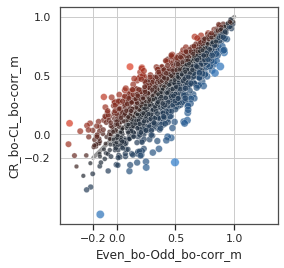

In [157]:

ax = sns.scatterplot(
    x=table.loc[table.comparison==null_var,'value'].values, 
    y=table.loc[table.comparison==test_var,'value'].values, 
    hue=table.loc[table.comparison==z_var,'value'].values, 
    size= abs(table.loc[table.comparison==z_var,'value'].values), 
    palette=pal, hue_norm=normalize, alpha=0.7, legend=False)

#ax.legend(loc='best')

plt.plot([-0.2,1], [-0.2,1], c='0.6', lw=4, zorder=-1)
ax.axis('square')

ax.set_xticks([-0.2, 0, 0.5, 1])
ax.set_yticks([-0.2, 0, 0.5, 1])
ax.set_xlabel(null_var)
ax.set_ylabel(test_var)

## overlap between thrsesholded 

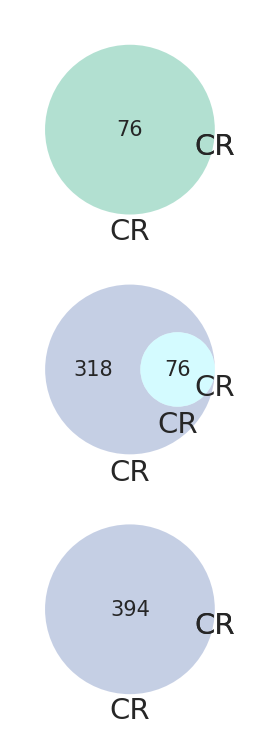

In [40]:
unit_type = 'cell'
thr = -2
savefig = False

zz_table = zrc.melt(id_vars=id_vars, value_vars= z_vars, var_name='comparison', value_name='value').copy()
zz_thr_unit_list = np.zeros(len(z_vars), dtype=object)
for ii, z_var in enumerate(z_vars):
    if unit_type=='all':
        zz_thr_unit_list[ii] = set(zz_table[(zz_table.comparison==z_var) & (zz_table.value<=thr)]['unit_id'].values)
    else:
        zz_thr_unit_list[ii] = set(zz_table[(zz_table.comparison==z_var) & (zz_table.value<=thr) & (zz_table.unit_type==unit_type)]['unit_id'].values)
        
        
f, ax = plt.subplots(3,1, figsize=(1,3), dpi=300, facecolor='w')
set_labels_fontsize = 7
set_fontsize = 5

pal = sns.color_palette("Set2",desat=1)

for ii in range(3):
    a = (ii)%4
    b = (ii+1)%4
    c = (ii+3)%4
    out = venn3([zz_thr_unit_list[a], zz_thr_unit_list[b], zz_thr_unit_list[c]],
                set_labels=[z_vars[a].split('_')[0], z_vars[b].split('_')[0],z_vars[c].split('_')[0]], 
                set_colors = [pal[a], pal[b], pal[c]],
                alpha=0.5, ax=ax[ii]) 
    for text in out.set_labels:
        text.set_fontsize(set_labels_fontsize)
    for x in range(len(out.subset_labels)):
        if out.subset_labels[x] is not None:
            out.subset_labels[x].set_fontsize(set_fontsize)
            
if savefig:
    p =info.paths['figures']
    figname = f"remmaping_overlap_{unit_type}.png"
    f.savefig(p/figname, dpi=600, bbox_inches='tight')

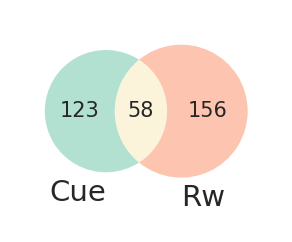

In [41]:
unit_type = 'all'
thr = -2
savefig = False

z_vars2 = [z_vars[0],z_vars[8]]
labels = ['Cue','Rw']

zz_table = zrc.melt(id_vars=id_vars, value_vars= z_vars2, var_name='comparison', value_name='value').copy()

zz_thr_unit_list = np.zeros(len(z_vars), dtype=object)
for ii, z_var in enumerate(z_vars2):
    if unit_type=='all':
        zz_thr_unit_list[ii] = set(zz_table[(zz_table.comparison==z_var) & (zz_table.value<=thr)]['unit_id'].values)
    else:
        zz_thr_unit_list[ii] = set(zz_table[(zz_table.comparison==z_var) & (zz_table.value<=thr) & (zz_table.unit_type==unit_type)]['unit_id'].values)
        
        
f, ax = plt.subplots(figsize=(1,1), dpi=300, facecolor='w')
set_labels_fontsize = 7
set_fontsize = 5

pal = sns.color_palette("Set2",desat=1)

out = venn2([zz_thr_unit_list[0], zz_thr_unit_list[1]],
            set_labels=labels, 
            set_colors = [pal[0], pal[1]],
            alpha=0.5, ax=ax) 

for text in out.set_labels:
    text.set_fontsize(set_labels_fontsize)
for x in range(len(out.subset_labels)):
    if out.subset_labels[x] is not None:
        out.subset_labels[x].set_fontsize(set_fontsize)
            
if savefig:
    p =info.paths['figures']
    figname = f"remmaping_2_overlap_{unit_type}__{zrc_str}.png"
    f.savefig(p/figname, dpi=600, bbox_inches='tight')

In [44]:
z_vars[0],z_vars[8]

('CR_bo-CL_bo-Even_bo-Odd_bo-corr_zm', 'Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zm')

0.7055873676904391


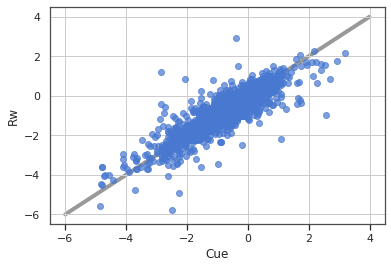

In [48]:
unit_type = 'cell'
z_vars2 = [z_vars[0],z_vars[4]]
zz_table = zrc.melt(id_vars=id_vars, value_vars= z_vars2, var_name='comparison', value_name='value').copy()
x=zz_table[zz_table.comparison==z_vars2[0]]
y=zz_table[zz_table.comparison==z_vars2[1]]
plt.scatter(x.value,y.value, alpha=0.7)
plt.plot([-6,4], [-6,4], c='0.6', lw=4, zorder=-1)
plt.xlabel('Cue')
plt.ylabel('Rw')
print(rs.kendall(x.value,y.value))

In [14]:

z_vars_of_interest = [z_vars[0],z_vars[4]]
print(z_vars_of_interest)

['CR_bo-CL_bo-Even_bo-Odd_bo-corr_zm', 'Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zm']


# relationship of remapping to behavior

In [15]:
b_table = info.get_behav_perf()
b_table = b_table.set_index('session')

In [16]:
unit_type = 'cell'
zz_table = zrc.melt(id_vars=id_vars, value_vars= z_vars_of_interest, var_name='comparison', value_name='value').copy()


conds = []
remap_names = []
for z in z_vars_of_interest:
    temp = z.split('-')
    conds.append(f"{temp[0].split('_')[0]}_{temp[1].split('_')[0]}") 
    remap_names.append(f"{temp[0]}-{temp[1]}-corr_m")

remap_names_dict = {}
for ii, cond in enumerate(conds):
    remap_names_dict[cond] = remap_names[ii]
    
zz_unit_list = {}
for ii, zvar in enumerate(z_vars_of_interest):
    if unit_type=='all':
        zz_unit_list[conds[ii]] = zz_table[(zz_table.comparison==zvar)]['unit_id'].values
    else:
        zz_unit_list[conds[ii]] = zz_table[(zz_table.comparison==zvar) & (zz_table.unit_type==unit_type)]['unit_id'].values

cond_thr_sessions = zrc.loc[zz_unit_list[conds[0]], 'session'].values
table = b_table.loc[cond_thr_sessions, ['subject', 'task', 'pct_correct', 'pct_sw_correct', 'pct_vsw_correct','pct_L_correct' ,'pct_R_correct']].copy()

table['score'] = zrc.loc[zz_unit_list[cond], remap_names_dict[cond]].values
table['n_score'] = -table['score']
table.corr()

,pct_correct,pct_sw_correct,pct_vsw_correct,pct_L_correct,pct_R_correct,score,n_score
pct_correct,1.000000,0.892688,0.758529,0.855310,0.676184,0.083066,-0.083066
pct_sw_correct,0.892688,1.000000,0.897000,0.809186,0.551365,-0.039918,0.039918
pct_vsw_correct,0.758529,0.897000,1.000000,0.756199,0.362526,-0.031326,0.031326
pct_L_correct,0.855310,0.809186,0.756199,1.000000,0.207090,0.053577,-0.053577
pct_R_correct,0.676184,0.551365,0.362526,0.207090,1.000000,0.097622,-0.097622
score,0.083066,-0.039918,-0.031326,0.053577,0.097622,1.000000,-1.000000
n_score,-0.083066,0.039918,0.031326,-0.053577,-0.097622,-1.000000,1.000000


In [11]:
def logit(p):
    return np.log(p/(1-p))
def get_task(session):
    return session.split("_")[1]

def get_reg_ci(x, y, reg_type='siegel', nboot=100,alpha=0.05, eval_x=None):
    n = len(x)
    assert n==len(y)
    
    boot_mb = np.zeros((nboot,2)) 
    
    if reg_type=='siegel':
        xp = y.copy()
        yp = x.copy()
        reg_func = scipy.stats.siegelslopes
    else:
        xp = x
        yp = y
        def reg_func(_x,_y):
            return np.polyfit(_x,_y,1)
        
    for boot in range(nboot):
        samps = np.random.choice(n,n)
        boot_mb[boot,:] = reg_func(xp[samps], yp[samps])
    
    
    if eval_x is None:
        xx = np.linspace(x.min(), x.max(), 100)
    else:
        xx = eval_x
    y_mb = boot_mb[:,1][:,np.newaxis]+np.outer(boot_mb[:,0],xx)
    y_bot, y_top = np.percentile(y_mb, np.array([alpha/2, 1-alpha/2])*100, axis=0)
        
    return y_bot, y_top, xx


def bootstrap_corr(x,y,n_boot=100,corr_method='kendall'):
    n = len(x)
    assert n==len(y)
    
    if corr_method=='kendall':
        r_func = rs.kendall
    else:
        r_func = rs.pearson
        
    r = np.zeros(n_boot)
    for b in range(n_boot):
        b_idx = np.random.choice(n,n)
        
        r[b]= r_func(x[b_idx], y[b_idx])
        
    return r

## single unit level

In [12]:
unit_types = ['cell','mua', 'all']
behav_scores = ['pct_correct', 'pct_sw_correct', 'pct_vsw_correct', 'pct_L_correct' ,'pct_R_correct']
remap_names_dict = {s.split("_")[0]: s for s in z_vars}
remap_names = list(remap_names_dict.keys())
b_table = info.get_behav_perf()
b_table = b_table.set_index('session')

zrc_b = zrc.copy()
b_cols = ['pct_correct', 'pct_sw_correct', 'pct_vsw_correct', 'pct_L_correct' ,'pct_R_correct']
for session in b_table.index:
    z_index = zrc_b.session==session 
    zrc_b.loc[z_index, b_cols] = b_table.loc[session, b_cols].values
    
zrc_b['task'] = zrc_b.session.apply(get_task)

tasks = ['all']+list(zrc_b.task.unique())


def get_behav_unit_table(remap_score, unit_type):

    if unit_type=='all':
        table = zrc_b.copy()
    else:
        table = zrc_b.loc[zrc_b.unit_type==unit_type].copy()

    table['score'] = table[remap_score]
    table['n_score'] = -table['score']

    return table
    
def behav_score_plot(remap_score=remap_measures, behav_score=behav_scores, unit_type=unit_types, corr_method=['kendall', 'pearson'], plot_ci=True):
    f,ax = plt.subplots(figsize=(1,1), dpi=300)
    sns.set_style(rc={"axes.edgecolor":'0.2',
                     'xtick.bottom': True,
                     'ytick.left': True})
    
    table = get_behav_unit_table(remap_score, unit_type)

    fontsize=6
    label_fontsize=7
    legend_fontsize=6
    
    r = np.around(table[[behav_score, 'score']].corr(method=corr_method).iloc[0,1],2)
    
    if r<0:
        sns.scatterplot(x='score', y=behav_score, data=table,  hue='score', size='n_score', palette='crest_r', 
                        legend=False, alpha=0.75, **{'linewidth':0.1, 'edgecolor':'k'}, ax=ax, sizes=(1,5))
    else:
        sns.scatterplot(x='score', y=behav_score, data=table,  hue='score', size='score', palette='crest', 
                        legend=False, alpha=0.75, **{'linewidth':0.1, 'edgecolor':'k'}, ax=ax, sizes=(1,5))
        
    
    temp = table[ [behav_score, 'score']].dropna()
    x = temp['score'].values
    y = temp[behav_score].values
    
    if corr_method=='pearson':
        m,b = np.polyfit(x,y,1)
    else:
        m,b = scipy.stats.siegelslopes(y,x)
  
    xx = np.linspace( x.min(),x.max(),100) 
    ax.plot(xx, m*xx + b, linewidth=1, color='#e46c5c', linestyle='-')
    
    
    ax.set_ylabel(r"$p_{se} (\%)$",fontsize=label_fontsize, labelpad=0)
    if 'corr_m' in remap_score:
        ax.set_xlabel(r"$\bar \tau$", fontsize=label_fontsize, labelpad=0)
    elif 'zm' in remap_score:
        
        if 'CR' in remap_score:
    #         ax.set_xticks([-5,0,3])
    #         ax.set_xlim([-6,3.1])
            ax.set_xticks([-3,0,3])
            ax.set_xlim([-4,3.1])
        elif 'Co' in remap_score:
            ax.set_xticks([-6,0,2])
            ax.set_xlim([-7,3.1])
            
        
        if 'CR' in remap_score:
            ax.set_xlabel(r"$\bar{z}_{\Delta \tau} \: Cue$", fontsize=label_fontsize, labelpad=0)
        elif 'Co' in remap_score:
            ax.set_xlabel(r"$\bar{z}_{\Delta \tau} \: Rw$", fontsize=label_fontsize, labelpad=0)

        else:
            ax.set_xlabel(r"$\bar{z}_{\Delta \tau}$", fontsize=label_fontsize, labelpad=0)

            

    ax.tick_params(axis="both", direction="out", length=2, width=1, color='0.2',  which='major', pad=1, labelsize=fontsize)
    ax.set_ylim(0.25,1.01)
    yticks = ax.get_yticks()
    ax.set_yticklabels((yticks*100).astype(int))
    sns.despine(ax=ax)
    
    xt = ax.get_xlim()[0]
    xt = xt+np.abs(xt)*0.1
    
    if corr_method=='kendall':
        ax.text(xt, 0.3, r"$\tau={}$".format(r), fontsize=legend_fontsize)
    else:
        ax.text(xt, 0.3, r"$\rho={}$".format(r), fontsize=legend_fontsize)
        
    ax.grid(linewidth=0.3)

    if plot_ci:
        if corr_method=='pearson':
            yb,yu,xx=get_reg_ci(x,y,reg_type='linear', eval_x=xx)
        else:
            yb,yu,xx=get_reg_ci(x,y, eval_x=xx)

        ax.fill_between(xx, yb, yu, alpha=0.4, color='#e46c5c', linewidth=0, zorder=10)
        
    return f
   
def savefig(null):
    f = o.result
    p = info.paths['figures']
    figname = f"remmaping_behav_{o.children[0].value}_{o.children[1].value}_{o.children[2].value}_{o.children[3].value}__{zrc_str}.png"
    f.savefig(p/figname, dpi=600, bbox_inches='tight', transparent=True)

w_remap_score = widgets.Dropdown(options=remap_measures)
w_behav_score = widgets.Dropdown(options=behav_scores)
w_unit_type = widgets.Dropdown(options=unit_types)
w_corr_method = widgets.Dropdown(options=['kendall','pearson'])
save_button = widgets.Button(description='Save Figure')
save_button.on_click(savefig)
    
ui = widgets.VBox([w_remap_score, w_behav_score, w_unit_type])
o = widgets.interactive(behav_score_plot, {'remap_score': w_remap_score, 'behav_score': w_behav_score, 'unit_type': w_unit_type, 'corr_method': w_corr_method})

display(o, save_button)


interactive(children=(Dropdown(description='remap_score', options=('CR-CL_corr', 'CR-CL_t_m', 'CR-CL_t_var', '…

Button(description='Save Figure', style=ButtonStyle())

In [48]:
w_remap_scores = widgets.Dropdown(options=remap_measures)
w_behav_scores = widgets.Dropdown(options=behav_scores)
w_null_scores = widgets.Dropdown(options=null_vars)
w_unit_type = widgets.Dropdown(options=unit_types)
w_tasks = widgets.Dropdown(options=tasks)

def evaluate_model(remap_score=remap_measures, behav_score=behav_scores, remap_null=null_vars, unit_type=unit_types, task=tasks, rescale_null=True, rescale_behav=True):

    temp = zrc_b[['subject', 'task','session', 'unit_type', remap_score, behav_score, remap_null]].copy()
    temp = temp.rename(columns={remap_score:'x', behav_score:'y', remap_null:'z'})
    temp = temp.dropna()
    
    if rescale_behav:
        temp['y'] = logit(temp['y'])
    if rescale_null:
        temp['z'] = rs.fisher_r2z(rs.kendall2pearson(temp['z']))
    
    vc_formula = {}
    if unit_type != 'all':
        temp = temp.loc[temp.unit_type==unit_type]
    else:
        vc_formula['unit_type']="0+C(unit_type)"
        
    if task != 'all':
        temp = temp.loc[temp.task==task]
    else:
        vc_formula['task'] = "1+C(task)"
        
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        mdf = smf.mixedlm(formula="y ~ 1 + x ", groups='subject', re_formula='1', vc_formula=vc_formula, data=temp).fit()
        mdnf = smf.mixedlm(formula="y ~ 1 ", groups='subject', re_formula='1',  vc_formula=vc_formula, data=temp).fit()
    print("Full")
    print(mdf.summary())
    print(f"RMSE: {np.sqrt(((temp.y- mdf.fittedvalues)**2).mean()):0.2f}")
    print(f"R2: {rs.get_r2(temp.y.values, mdf.fittedvalues.values)[0]:0.2f}")
    print()
    print("Null")
    print(mdnf.summary())
    print(f"RMSE: {np.sqrt(((temp.y- mdnf.fittedvalues)**2).mean()):0.2f}")
    print(f"R2: {rs.get_r2(temp.y.values, mdnf.fittedvalues.values)[0]:0.2f}")
    print()
    print(f"LRT = {(mdf.llf-mdnf.llf):0.2f}")
    
    return temp, mdf, mdnf

o = widgets.interactive(evaluate_model, {'remap_score': w_remap_scores, 'behav_score': w_behav_scores, 'unit_type': w_unit_type, 'remap_null':w_null_scores, 'task': w_tasks})

display(o)

interactive(children=(Dropdown(description='remap_score', options=('CR-CL_corr', 'CR-CL_t_m', 'CR-CL_t_var', '…

In [49]:
o.result[1].pvalues

Intercept      1.406804e-02
x              1.220945e-22
subject Var             NaN
task Var       6.374190e-02
dtype: float64

In [72]:
table = o.result
mdf = smf.mixedlm(formula="y ~ 1 + x ", groups='subject', re_formula='1', vc_formula={'task': "1+C(task)"}, data=table).fit()
mdnf = smf.mixedlm(formula="y ~ 1 ", groups='subject', re_formula='1',  vc_formula={'task': "1+C(task)"}, data=table).fit()

                            OLS Regression Results                            
Dep. Variable:                     nr   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     35.41
Date:                Fri, 17 Dec 2021   Prob (F-statistic):           4.73e-09
Time:                        01:18:41   Log-Likelihood:                -275.16
No. Observations:                 559   AIC:                             554.3
Df Residuals:                     557   BIC:                             563.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0450      0.018     -2.447      0.0

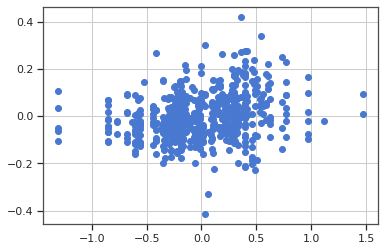

In [73]:
table2 = table.copy()
table2['nr'] = mdnf.resid
ols_residual_fit = smf.ols("nr~1+x", data=table2).fit() 
print(ols_residual_fit.summary())

plt.scatter(table2['nr'], ols_residual_fit.fittedvalues) 

## mean of units by session

In [53]:
w_remap_scores = widgets.Dropdown(options=remap_measures)
w_behav_scores = widgets.Dropdown(options=behav_scores)
w_null_scores = widgets.Dropdown(options=null_vars)
w_unit_type = widgets.Dropdown(options=unit_types)
w_tasks = widgets.Dropdown(options=tasks)


def plot_session_mean_remap_2_behav(remap_score=remap_measures, behav_score=behav_scores, remap_null=null_vars, unit_type=unit_types, 
                                    corr_method=['kendall', 'pearson'], task=tasks, rescale_null=True, rescale_behav=True, plot_ci=True, legend=True):

    f,ax = plt.subplots(figsize=(1,1), dpi=300)
    sns.set_style(rc={"axes.edgecolor":'0.2',
                     'xtick.bottom': True,
                     'ytick.left': True})
    
    pal = sns.color_palette('deep')

    fontsize=6
    label_fontsize=7
    legend_fontsize=6
    scatter_marker_sizes = (2,8)
    
    marker_scale = 1
    marker_alpha = 0.75
    
    legend_markersize = 2
    legend_min_marker_sizes=2
    
    temp = zrc_b[['subject', 'task','session', 'unit_type']].copy()
    
    temp['x'] = zrc_b[remap_score].copy()
    temp['y'] = zrc_b[behav_score].copy()
    temp['z'] = zrc_b[remap_null].copy()
    
    temp = temp.dropna()
    
    if unit_type != 'all':
        temp = temp.loc[temp.unit_type==unit_type]
    if task != 'all':
        temp = temp.loc[temp.task==task]
    
    if rescale_behav:
        temp['y'] = logit(temp['y'])
    if rescale_null:
        temp['z'] = rs.fisher_r2z(rs.kendall2pearson(temp['z']))
        
    session_means = temp.groupby(['subject', 'session']).mean()
    session_means['n'] = temp.groupby(['subject', 'session']).size()

    sns.scatterplot(x='x', y='y', hue='subject', size='n', data=session_means,
                        legend=legend, alpha=marker_alpha, hue_order=info.subjects, **{'linewidth':0.1, 'edgecolor':'k'}, ax=ax, sizes=scatter_marker_sizes)
   
    
    if legend:
        l=ax.get_legend()
        # hack to get seaborn scaled markers:
        o = []
        #o.append(plt.Line2D([-1],[0], lw=0, label='# units'))
        on_numerics = False
        for l_handle in l.legendHandles:
            if on_numerics:
                label =l_handle.properties()['label'] 
                l_handle.set_label = "n="+label
                o.append(l_handle)
            elif l_handle.properties()['label']=='n':
                on_numerics = True
        legend_size_marker_handles =  [o[ii] for ii in [0,-1]]
        l.remove()

    x = session_means['x']
    y = session_means['y']
    
    if corr_method=='pearson':
        m,b = np.polyfit(x,y,1)
    else:
        m,b = scipy.stats.siegelslopes(y,x)
  
    xx = np.linspace( x.min(),x.max(),100) 
    ax.plot(xx, m*xx + b, linewidth=1, color='0.3', linestyle='-')
    
    if plot_ci:
        if corr_method=='pearson':
            yb,yu,xx=get_reg_ci(x,y,reg_type='linear', eval_x=xx)
        else:
            yb,yu,xx=get_reg_ci(x,y, eval_x=xx)

        ax.fill_between(xx, yb, yu, alpha=0.4, color='#86b4cb', linewidth=0, zorder=-1)
    ax.grid(linewidth=0.3)

    ax.tick_params(axis="both", direction="out", length=2, width=1, color='0.2',  which='major', pad=1, labelsize=fontsize)
    
    if not rescale_behav:
        ax.set_ylim(0.25,1.01)
        yticks = ax.get_yticks()
        ax.set_yticklabels((yticks*100).astype(int))
        #ax.set_ylabel("Task Perf. [%]",fontsize=label_fontsize, labelpad=0)
        ax.set_ylabel(r"$p_{se} (\%)$",fontsize=label_fontsize, labelpad=0)

    else:
        ax.set_ylabel("Task Perf. [logit]", fontsize=label_fontsize, labelpad=0)
    
    if 'zm' in remap_score:
        if 'CR' in remap_score:
    #         ax.set_xticks([-4,-2,0,2])
    #         ax.set_xlim([-5,2.5])
            ax.set_xticks([-2,0,2])
            ax.set_xlim([-2.5,1])
            ax.set_xlabel(r"$\bar{z}_{\Delta \tau \: se} \: Cue$",
                          fontsize=label_fontsize, labelpad=0)
        elif 'Co' in remap_score:
            ax.set_xticks([-4,0,2])
            ax.set_xlim([-5,3])
            ax.set_xlabel(r"$\bar{z}_{\Delta \tau \: se} \: Rw$", 
                          fontsize=label_fontsize, labelpad=0)

        else:
            ax.set_xlabel(r"$\bar{z}_{\Delta \tau-se}$", fontsize=label_fontsize, labelpad=0)
    
    sns.despine(ax=ax)
    if legend:
        xt=1.01
    else:
        xt = 0.05
    r = np.around(session_means[['x', 'y']].corr(method=corr_method).iloc[0,1],2)
    if corr_method=='kendall':
        ax.text(xt, 0.05, r"$\tau$={}".format(r), fontsize=legend_fontsize, transform=ax.transAxes,)
    else:
        ax.text(xt, 0.05, r"$\rho$={}".format(r), fontsize=legend_fontsize, transform=ax.transAxes,)
        
    if legend:
        legend_params = dict(handlelength = 0.25, handletextpad=0.2, bbox_to_anchor=[1.0,1.1], loc='upper left',
                         frameon=False, fontsize=legend_fontsize, markerscale=marker_scale, labelspacing=0.1)

        legend_elements = []
        for ii, ss in enumerate(info.subjects[:-1]):
            legend_elements.append(plt.Line2D([0],[0], marker='o', alpha=marker_alpha, markersize=legend_markersize, 
                                              lw=0, mew=0,color=pal[ii], label=f"s$_{{{ii+1}}}$") )
        l1 = ax.legend(handles=legend_elements, **legend_params)

                    
        legend_params = dict(handlelength = 0.3, handletextpad=0.5, bbox_to_anchor=[1.0,0.1], loc='lower left',
                         frameon=False, fontsize=legend_fontsize-1, markerscale=marker_scale, labelspacing=0.2)
                           
        l2 = ax.add_artist(plt.legend(handles=legend_size_marker_handles, **legend_params))
        ax.add_artist(l1)

    return f, session_means

def savefig(null):
    f = o.result[0]
    p = info.paths['figures']
    figname = f"remmaping_session_means_behav_{o.children[0].value}_{o.children[1].value}_{o.children[3].value}_{o.children[5].value}_{zrc_str}"
    if o.children[7].value==1:
        figname+='rescale_behav'
    figname+='.png'
    f.savefig(p/figname, dpi=600, bbox_inches='tight', transparent=True)


o = widgets.interactive(plot_session_mean_remap_2_behav, {'remap_score': w_remap_scores, 'behav_score': w_behav_scores, 'unit_type': w_unit_type, 'remap_null':w_null_scores, 'task': w_tasks})

save_button = widgets.Button(description='Save Figure')
save_button.on_click(savefig)
display(o,save_button)

interactive(children=(Dropdown(description='remap_score', options=('CR-CL_corr', 'CR-CL_t_m', 'CR-CL_t_var', '…

Button(description='Save Figure', style=ButtonStyle())

In [55]:
w_remap_scores = widgets.Dropdown(options=remap_measures)
w_behav_scores = widgets.Dropdown(options=behav_scores)
w_null_scores = widgets.Dropdown(options=null_vars)
w_unit_type = widgets.Dropdown(options=unit_types)
w_tasks = widgets.Dropdown(options=tasks)

def evaluate_model(remap_score=remap_measures, behav_score=behav_scores, remap_null=null_vars, unit_type=unit_types, task=tasks, rescale_null=True, rescale_behav=True):

    temp = zrc_b[['subject', 'task','session', 'unit_type', remap_score, behav_score, remap_null]].copy()
    temp = temp.rename(columns={remap_score:'x', behav_score:'y', remap_null:'z'})
    temp = temp.dropna()
    
    if rescale_behav:
        temp['y'] = logit(temp['y'])
        
    if rescale_null:
        temp['z'] = rs.fisher_r2z(rs.kendall2pearson(temp['z']))
    
    if unit_type!='all':
        temp = temp.loc[temp.unit_type==unit_type]
        
    vc_formula = {}
    if task != 'all':
        temp = temp.loc[temp.task==task]
    else:
        vc_formula['task'] = "1+C(task)"
        
    session_means = temp.groupby(['subject', 'task', 'session']).mean()
    session_means = session_means.reset_index()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        mdf = smf.mixedlm(formula="y ~ 1 + x", groups='subject', re_formula='1', vc_formula=vc_formula, data=session_means).fit()
        mdnf = smf.mixedlm(formula="y ~ 1", groups='subject', re_formula='1',  vc_formula=vc_formula, data=session_means).fit()
    print("Full")
    print(mdf.summary())
    print(f"RMSE: {np.sqrt(((session_means.y- mdf.fittedvalues)**2).mean()):0.2f}")
    print(f"R2: {rs.get_r2(session_means.y.values, mdf.fittedvalues.values)[0]:0.2f}")
    print()
    print("Null")
    print(mdnf.summary())
    print(f"RMSE: {np.sqrt(((session_means.y- mdnf.fittedvalues)**2).mean()):0.2f}")
    print(f"R2: {rs.get_r2(session_means.y.values, mdnf.fittedvalues.values)[0]:0.2f}")
    print()
    print(f"LRT = {(mdf.llf-mdnf.llf):0.2f}")
    
    return session_means, mdf, mdnf

o = widgets.interactive(evaluate_model, {'remap_score': w_remap_scores, 'behav_score': w_behav_scores, 'unit_type': w_unit_type, 'remap_null':w_null_scores, 'task': w_tasks})
display(o)


interactive(children=(Dropdown(description='remap_score', options=('CR-CL_corr', 'CR-CL_t_m', 'CR-CL_t_var', '…

In [56]:
o.result[1].pvalues

Intercept      4.880174e-03
x              7.511920e-11
subject Var             NaN
task Var       7.582532e-02
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                     nr   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.750
Date:                Fri, 17 Dec 2021   Prob (F-statistic):              0.100
Time:                        12:35:07   Log-Likelihood:                -56.356
No. Observations:                 103   AIC:                             116.7
Df Residuals:                     101   BIC:                             122.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1659      0.108     -1.531      0.1

<AxesSubplot:xlabel='nr', ylabel='fit'>

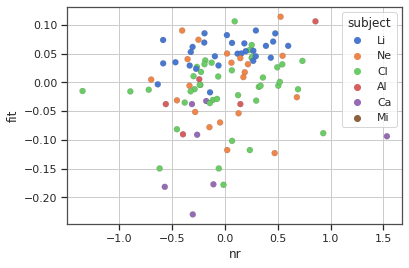

In [169]:
table = o.result[0]
mdf = o.result[1]
mdnf = o.result[2]

table2 = table.copy()
table2['nr'] = mdnf.resid
ols_residual_fit = smf.ols("nr~1+x", data=table2).fit() 
print(ols_residual_fit.summary())

table2['fit']=ols_residual_fit.fittedvalues
sns.scatterplot(x='nr', y='fit', hue='subject', data=table2, hue_order=info.subjects, **{'linewidth':0.1, 'edgecolor':'k'})

In [301]:
mdf.pvalues['x']

2.354539301984453e-14

In [315]:
unit_type='all'
task = 'all'
behav_score = 'pct_correct'
remap_null = null_vars[0]

temp = zrc_b[['subject', 'task','session', 'unit_type', z_vars2[0], z_vars[1], behav_score, remap_null]].copy()
temp = temp.rename(columns={z_vars[0]:'cue', z_vars[1]:'rw', behav_score:'y', remap_null:'z'})
temp = temp.dropna()

temp['y'] = logit(temp['y'])
temp['z'] = rs.fisher_r2z(rs.kendall2pearson(temp['z']))

if unit_type!='all':
    temp = temp.loc[temp.unit_type==unit_type]

vc_formula = {}
if task != 'all':
    temp = temp.loc[temp.task==task]
else:
    vc_formula['task'] = "1+C(task)"

session_means = temp.groupby(['subject', 'task', 'session']).mean()
session_means = session_means.reset_index()
session_means

,subject,task,session,cue,rw,y,z
0,Al,T3g,AL_T3g_101218,-0.306485,0.078526,0.775385,0.446637
1,Al,T3g,Al_T3g_092618,0.001422,0.016532,-0.105361,0.164243
2,Al,T3g,Al_T3g_092718,0.018646,0.055128,0.211309,0.396287
3,Al,T3g,Al_T3g_092818,-0.418050,-0.408561,0.057158,0.427507
4,Al,T3g,Al_T3g_100218,-0.400685,-0.117762,0.526093,0.455098
...,...,...,...,...,...,...,...
131,Ne,T3i,NE_T3i_070518,-0.302694,-0.504837,-0.028171,0.385834
132,Ne,T3i,NE_T3i_071018,-0.901937,-0.637815,0.551177,1.201666
133,Ne,T3i,NE_T3i_072518,0.534671,0.408225,0.569533,0.338017
134,Ne,T3i,Ne_T3i_060818,0.273881,0.414451,0.780159,0.585406


In [318]:
mdf = smf.mixedlm(formula="y ~ 1 + cue+rw", groups='subject', re_formula='1', vc_formula=vc_formula, data=session_means).fit()
mdnf = smf.mixedlm(formula="y ~ 1", groups='subject', re_formula='1',  vc_formula=vc_formula, data=session_means).fit()

In [319]:
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y       
No. Observations: 136     Method:             REML    
No. Groups:       5       Scale:              0.2026  
Min. group size:  14      Log-Likelihood:     -97.9878
Max. group size:  44      Converged:          No      
Mean group size:  27.2                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.816    0.229  3.560 0.000  0.367  1.265
cue          0.267    0.171  1.561 0.119 -0.068  0.602
rw          -0.700    0.191 -3.665 0.000 -1.074 -0.325
subject Var  0.006                                    
task Var     0.239    0.300                           



In [322]:
ols_fit = smf.ols("y ~ 1 + cue", data=session_means).fit()
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     37.92
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           8.01e-09
Time:                        14:28:11   Log-Likelihood:                -110.09
No. Observations:                 136   AIC:                             224.2
Df Residuals:                     134   BIC:                             230.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7644      0.064     12.021      0.0

In [323]:
ols_fit = smf.ols("y ~ 1 + rw", data=session_means).fit()
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     52.02
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           3.65e-11
Time:                        14:28:26   Log-Likelihood:                -104.73
No. Observations:                 136   AIC:                             213.5
Df Residuals:                     134   BIC:                             219.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7156      0.063     11.428      0.0

## slope of remap by mean across session vs subject

In [58]:
w_remap_scores = widgets.Dropdown(options=remap_measures)
w_behav_scores = widgets.Dropdown(options=behav_scores)
w_null_scores = widgets.Dropdown(options=null_vars)
w_unit_type = widgets.Dropdown(options=unit_types)
w_tasks = widgets.Dropdown(options=tasks)

def plot_subject_session_mean_remap_2_behav(remap_score=remap_measures, behav_score=behav_scores, remap_null=null_vars, unit_type=unit_types, 
                                            corr_method=['kendall', 'pearson'], task=tasks, rescale_null=True, rescale_behav=True, plot_ci=True, legend=True):

    f,ax = plt.subplots(figsize=(0.75,0.75), dpi=300)
    fontsize=7
    x_split = 0.75
    ax.set_position([0,0,x_split,1])

    pal = sns.color_palette("tab10", desat=0.8)
    sns.set_style(rc={"axes.edgecolor":'0.2',
                     'xtick.bottom': True,
                     'ytick.left': True})
    fontsize=7
    label_fontsize=8
    legend_fontsize=5
    scatter_marker_sizes = (2,8)
    
    marker_scale = 1
    marker_alpha = 0.75
    
    legend_markersize = 2
    legend_min_marker_sizes=2

    temp = zrc_b[['subject', 'task','session', 'unit_type', remap_score, behav_score, remap_null]].copy()
    temp = temp.rename(columns={remap_score:'x', behav_score:'y', remap_null:'z'})
    temp = temp.dropna()
    
    if rescale_behav:
        temp['y'] = logit(temp['y'])
        
    if rescale_null:
        temp['z'] = rs.fisher_r2z(rs.kendall2pearson(temp['z']))
    
    if unit_type!='all':
        temp = temp.loc[temp.unit_type==unit_type]
        
    vc_formula = {}
    if task != 'all':
        temp = temp.loc[temp.task==task]
    else:
        vc_formula['task'] = "1+C(task)"
        
    table = temp.groupby(['subject', 'task', 'session']).mean()
    table = table.reset_index()
    np.random.seed(0)
    subjects = info.subjects
    n_subjects= len(subjects)
    n_boot = 500
    rb = np.zeros((n_subjects,n_boot))*np.nan
    for ii, ss in enumerate(subjects):
        sub_table = table.loc[table.subject==ss,['x','y']]
        rb[ii] = bootstrap_corr(sub_table.x.values,sub_table.y.values, n_boot)
    boot_behav_remap =pd.DataFrame(rb.T, columns=info.subjects).melt(value_name='r', var_name='subject')

    subset = boot_behav_remap.dropna()
    sns.pointplot(x='subject', y='r', hue='subject', data=subset, linewidth=0.1, ax=ax, join=False, scale=0.3, errwidth=1, ci='sd', palette=pal, estimator=np.mean)
    ax.get_legend().remove()

    ax.set_ylim(-1.01,1.01)
    ax.set_yticks([-1,0,1])
    ax.set_yticklabels([-1, 0, 1], fontsize=fontsize)
    ax.set_ylabel(r'$\tau_{(\bar z_{\Delta \tau}, p_{se})}$', 
                  fontsize=fontsize)

    ax.set_xticklabels([f"s$_{{{ii}}}$" for ii in range(1,len(subjects))], fontsize=fontsize)
    ax.set_xlabel('Subjects',fontsize=fontsize)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    #sns.despine(offset=2) #ax.tick_params(axis="both", direction="in", length=2, width=0.8, color="0.5",  which='major', pad=1)
    ax.tick_params(axis="both", direction="out", length=2, width=1, color='0.2',  which='major', pad=1, labelsize=fontsize)
    ax.grid(linewidth=0.3)

    # summary
    ax = f.add_axes([x_split,0,1-x_split,1])

    scale = 0.05
    subset2 = boot_behav_remap.groupby("subject").mean().loc[info.subjects[:-1]]
    subset2['color'] = pal[:len(subset2)] 
    x_locs = np.random.rand(len(subset2))*scale
    x_locs = x_locs-x_locs.mean()
    ax.scatter(x_locs, subset2.r, s=5, c=subset2.color, alpha=0.8, lw=0, zorder=10) 

    ax.plot(np.array([-1,1])*scale, [subset2.r.mean()]*2, lw=1, color='0.2')
    ax.set_ylim(-1.01,1.01)
    ax.set_yticks([-1,0,1])
    ax.set_yticklabels([])

    ax.set_xlim(np.array([-1,1])*scale*2)
    ax.set_xticks([0])
    ax.set_xticklabels( [r" $\bar s$ "], fontsize=fontsize)
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    ax.tick_params(axis="both", direction="out", length=2, width=1, color='0.2',  which='major', pad=1, labelsize=fontsize)
    ax.tick_params(axis='y', left=False) 
    ax.grid(linewidth=0.3)

    return f

def savefig(null):
    f = o.result
    p = info.paths['figures']
    figname = f"remmaping_subject_session_means_behav_{o.children[0].value}_{o.children[1].value}_{o.children[3].value}_{o.children[5].value}_{zrc_str}.png"
    f.savefig(p/figname, dpi=600, bbox_inches='tight')


o = widgets.interactive(plot_subject_session_mean_remap_2_behav, {'remap_score': w_remap_scores, 'behav_score': w_behav_scores, 'unit_type': w_unit_type, 'remap_null':w_null_scores, 'task': w_tasks})

save_button = widgets.Button(description='Save Figure')
save_button.on_click(savefig)
display(o,save_button)



interactive(children=(Dropdown(description='remap_score', options=('CR-CL_corr', 'CR-CL_t_m', 'CR-CL_t_var', '…

Button(description='Save Figure', style=ButtonStyle())

In [136]:
z_var = z_vars[0]
unit_type = 'cell'
zrc.loc[zrc.unit_type==unit_type].sort_values(z_var).head(100).session.value_counts()

Cl_T3g_012419      6
Cl_T3g_120518      5
Cl_T3g_010819      4
Cl_T3g_120918      4
Cl_T3g_012919      3
NE_T3g_061218      3
Cl_T3g_122218      3
Li_T3g_060418      3
Li_T3g_070918      3
Li_T3g_072518      3
Cl_T3g_011419      3
NE_T3g_061518      3
Cl_T3g_113018      3
NE_T3g_052918      3
Cl_T3g_120618      3
Li_T3g_062818      3
Li_T3g_070618      3
Li_T3g_061818      3
Cl_T3g_020719      2
NE_T3g_053118      2
Cl_T3g_010619      2
Li_T3g_060118      2
Li_T3g_073018      2
Li_T3g_062918      2
Li_T3g_072618      2
Cl_T3g_122118      2
Li_T3g_061318      2
Cl_T3g_020619      1
Cl_T3g_120318      1
Li_T3g_061418      1
Cl_T3g_123118      1
Li_T3g_071018      1
Cl_T3g_011619      1
Li_T3g_080118      1
Li_T3g_080318      1
Cl_T3i_021419      1
Li_T3i_060618      1
Ne_T3g_060118      1
NE_T3g_070518      1
Cl_T3g_020519      1
NE_T3i_061118      1
Cl_T3g_120718      1
Li_T3g_062018      1
Li_T3g_062718      1
Li_T3i_061118      1
Cl_T3g_010919      1
Cl_T3g_121418_0    1
Cl_T3g_010318

## population level remaping

In [16]:
%%time
ei = reload(ei)
overwrite=False
info = ei.SummaryInfo()
pzrc = info.get_pop_zone_rates_remap(overwrite=overwrite)

CPU times: user 25.8 ms, sys: 23 µs, total: 25.8 ms
Wall time: 25.2 ms


In [17]:
pzrc.head()

,subject,session,session_pct_cov,session_valid,n_session_all,n_session_cells,n_session_muas,pop_type,CR_bo-CL_bo-corr_m,CR_bo-CL_bo-corr_z,...,CR_bo-CL_bo-Even_bo-Odd_bo-corr_zt,CR_bo-CL_bo-Even_bo-Odd_bo-corr_ztp,Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zm,Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zp,Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zt,Co_bo-Inco_bo-Even_bo-Odd_bo-corr_ztp,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zm,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zp,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zt,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_ztp
0,Li,Li_T3g_052818,0,0,2,0,2,cells,NaN,NaN,...,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,1.000000e+00,NaN,NaN
1,Li,Li_T3g_052818,0,0,2,0,2,muas,0.235092,0.382072,...,-1.435433,1.543158e-01,0.130228,6.147307e-59,1.050551,2.960224e-01,-0.543050,6.274768e-130,-2.716187,7.794561e-03
2,Li,Li_T3g_052818,0,0,2,0,2,all,0.235092,0.382072,...,-1.435433,1.543158e-01,0.130228,6.147307e-59,1.050551,2.960224e-01,-0.543050,6.274768e-130,-2.716187,7.794561e-03
3,Li,Li_T3g_052918,0,0,14,6,8,cells,0.707729,1.455152,...,-23.319510,5.281613e-42,-5.729448,0.000000e+00,-30.469076,4.247630e-52,-8.083766,0.000000e+00,-45.138985,7.524665e-68
4,Li,Li_T3g_052918,0,0,14,6,8,muas,0.656034,1.284937,...,-19.137712,4.866298e-35,-3.993051,0.000000e+00,-27.501583,3.735268e-48,-7.018437,0.000000e+00,-43.732122,1.491006e-66


In [21]:

remap_measures2 = pzrc.columns[9:]
remap_measures2

Index(['CR_bo-CL_bo-corr_z', 'Co_bo-Inco_bo-corr_m', 'Co_bo-Inco_bo-corr_z',
       'Co_bi-Inco_bi-corr_m', 'Co_bi-Inco_bi-corr_z', 'Even_bo-Odd_bo-corr_m',
       'Even_bo-Odd_bo-corr_z', 'Even_bi-Odd_bi-corr_m',
       'Even_bi-Odd_bi-corr_z', 'CR_bo-CL_bo-Even_bo-Odd_bo-corr_zm',
       'CR_bo-CL_bo-Even_bo-Odd_bo-corr_zp',
       'CR_bo-CL_bo-Even_bo-Odd_bo-corr_zt',
       'CR_bo-CL_bo-Even_bo-Odd_bo-corr_ztp',
       'Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zm',
       'Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zp',
       'Co_bo-Inco_bo-Even_bo-Odd_bo-corr_zt',
       'Co_bo-Inco_bo-Even_bo-Odd_bo-corr_ztp',
       'Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zm',
       'Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zp',
       'Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zt',
       'Co_bi-Inco_bi-Even_bi-Odd_bi-corr_ztp'],
      dtype='object')

In [18]:
pzrc_b = pzrc.copy()

b_cols = ['pct_correct', 'pct_sw_correct', 'pct_vsw_correct', 'pct_L_correct' ,'pct_R_correct']
for session in b_table.index:
    z_index = pzrc_b.session==session 
    pzrc_b.loc[z_index, b_cols] = b_table.loc[session, b_cols].values
    
pzrc_b['task'] = pzrc_b.session.apply(get_task)


In [19]:
pzrc_b.head()

,subject,session,session_pct_cov,session_valid,n_session_all,n_session_cells,n_session_muas,pop_type,CR_bo-CL_bo-corr_m,CR_bo-CL_bo-corr_z,...,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zm,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zp,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_zt,Co_bi-Inco_bi-Even_bi-Odd_bi-corr_ztp,pct_correct,pct_sw_correct,pct_vsw_correct,pct_L_correct,pct_R_correct,task
0,Li,Li_T3g_052818,0,0,2,0,2,cells,NaN,NaN,...,NaN,1.000000e+00,NaN,NaN,0.704918,0.75000,0.809524,0.666667,0.735294,T3g
1,Li,Li_T3g_052818,0,0,2,0,2,muas,0.235092,0.382072,...,-0.543050,6.274768e-130,-2.716187,7.794561e-03,0.704918,0.75000,0.809524,0.666667,0.735294,T3g
2,Li,Li_T3g_052818,0,0,2,0,2,all,0.235092,0.382072,...,-0.543050,6.274768e-130,-2.716187,7.794561e-03,0.704918,0.75000,0.809524,0.666667,0.735294,T3g
3,Li,Li_T3g_052918,0,0,14,6,8,cells,0.707729,1.455152,...,-8.083766,0.000000e+00,-45.138985,7.524665e-68,0.843575,0.84375,0.865385,0.825581,0.860215,T3g
4,Li,Li_T3g_052918,0,0,14,6,8,muas,0.656034,1.284937,...,-7.018437,0.000000e+00,-43.732122,1.491006e-66,0.843575,0.84375,0.865385,0.825581,0.860215,T3g


In [22]:
pop_types = ['cells','muas','all']
w_remap_scores = widgets.Dropdown(options=remap_measures2)
w_behav_scores = widgets.Dropdown(options=behav_scores)
w_pop_type = widgets.Dropdown(options=pop_types)
w_tasks = widgets.Dropdown(options=tasks)


def plot_session_pop_remap_behav(remap_score=remap_measures2, behav_score=behav_scores, pop_type=pop_types, 
                                    corr_method=['kendall', 'pearson'], task=tasks, rescale_behav=True, plot_ci=True, legend=True):

    f,ax = plt.subplots(figsize=(1,1), dpi=300)
    sns.set_style(rc={"axes.edgecolor":'0.2',
                     'xtick.bottom': True,
                     'ytick.left': True})
    
    pal = sns.color_palette("deep")

    fontsize=6
    label_fontsize=7
    legend_fontsize=6
    scatter_marker_sizes = (2,8)
    
    marker_scale = 1
    marker_alpha = 0.75
    
    legend_markersize = 2
    legend_min_marker_sizes=2
    
    
    temp = pzrc_b[['subject', 'task','session', 'n_session_' + pop_type, 'pop_type']].copy()
    temp = temp.rename(columns={'n_session_' + pop_type:'n_units'})

    
    temp['x'] = pzrc_b[remap_score].copy()
    temp['y'] = pzrc_b[behav_score].copy()
    
    
    temp = temp.loc[temp.pop_type==pop_type]
    
    temp = temp.dropna()
    temp = temp.reset_index(drop=True)
    
    
    if rescale_behav:
        temp['y'] = logit(temp['y'])


    sns.scatterplot(x='x', y='y', hue='subject', size='n_units', data=temp,
                    legend=legend, alpha=marker_alpha, hue_order=info.subjects, 
                    **{'linewidth':0.1, 'edgecolor':'k'}, ax=ax, sizes=scatter_marker_sizes)
   
    
    if legend:
        l=ax.get_legend()
        # hack to get seaborn scaled markers:
        o = []
        #o.append(plt.Line2D([-1],[0], lw=0, label='# units'))
        on_numerics = False
        for l_handle in l.legendHandles:
            if on_numerics:
                label =l_handle.properties()['label'] 
                l_handle.set_label = "n="+label
                o.append(l_handle)
            elif l_handle.properties()['label']=='n_units':
                on_numerics = True
        legend_size_marker_handles =  [o[ii] for ii in [0,-1]]
        l.remove()

    x = temp['x']
    y = temp['y']
    
    if corr_method=='pearson':
        m,b = np.polyfit(x,y,1)
    else:
        m,b = scipy.stats.siegelslopes(y,x)
  
    xx = np.linspace( x.min(),x.max(),100) 
    ax.plot(xx, m*xx + b, linewidth=1, color='0.3', linestyle='-')
    
    if plot_ci:
        if corr_method=='pearson':
            yb,yu,xx=get_reg_ci(x,y,reg_type='linear', eval_x=xx)
        else:
            yb,yu,xx=get_reg_ci(x,y, eval_x=xx)

        ax.fill_between(xx, yb, yu, alpha=0.4, color='#86b4cb', linewidth=0, zorder=-1)
    ax.grid(linewidth=0.3)

    ax.tick_params(axis="both", direction="out", length=2, width=1, color='0.2',  which='major', pad=1, labelsize=fontsize)
    
    if not rescale_behav:
        ax.set_ylim(0.25,1.01)
        yticks = ax.get_yticks()
        ax.set_yticklabels((yticks*100).astype(int))
        #ax.set_ylabel("Task Perf. [%]",fontsize=label_fontsize, labelpad=0)
        ax.set_ylabel(r"$p_{se} (\%)$",fontsize=label_fontsize, labelpad=0)

    else:
        ax.set_ylabel("Task Perf. [logit]", fontsize=label_fontsize, labelpad=0)
    
    if 'zm' in remap_score:
        ax.set_xticks([-14,-7, 0, 7])
        ax.set_xlim([-20,10])
    
    if 'CR' in remap_score:
        ax.set_xlabel(r"$\bar{z}_{\Delta \tau \: se} \: Cue$", fontsize=label_fontsize, labelpad=0)
    elif 'Co' in remap_score:
        ax.set_xlabel(r"$\bar{z}_{\Delta \tau \: se} \: Rw$", fontsize=label_fontsize, labelpad=0)

    else:
        ax.set_xlabel(r"$\bar{z}_{\Delta \tau-se}$", fontsize=label_fontsize, labelpad=0)
    
    sns.despine(ax=ax)
    if legend:
        xt=1.01
    else:
        xt = 0.05
    
    r = np.around(temp[['x', 'y']].corr(method=corr_method).iloc[0,1],2)
    if corr_method=='kendall':
        ax.text(xt, 0.05, r"$\tau$={}".format(r), fontsize=legend_fontsize, transform=ax.transAxes,)
    else:
        ax.text(xt, 0.05, r"$\rho$={}".format(r), fontsize=legend_fontsize, transform=ax.transAxes,)
        
    if legend:
        legend_params = dict(handlelength = 0.25, handletextpad=0.2, bbox_to_anchor=[1.0,1.1], loc='upper left',
                         frameon=False, fontsize=legend_fontsize, markerscale=marker_scale, labelspacing=0.1)

        legend_elements = []
        for ii, ss in enumerate(info.subjects[:-1]):
            legend_elements.append(plt.Line2D([0],[0], marker='o', alpha=marker_alpha, markersize=legend_markersize, 
                                              lw=0, mew=0,color=pal[ii], label=f"s$_{{{ii+1}}}$") )
        l1 = ax.legend(handles=legend_elements, **legend_params)

                    
        legend_params = dict(handlelength = 0.3, handletextpad=0.5, bbox_to_anchor=[1.0,0.1], loc='lower left',
                         frameon=False, fontsize=legend_fontsize-1, markerscale=marker_scale, labelspacing=0.2)
                           
        l2 = ax.add_artist(plt.legend(handles=legend_size_marker_handles, **legend_params))
        ax.add_artist(l1)

    return f, temp

def savefig(null):
    f = o.result[0]
    p = info.paths['figures']
    figname = f"pop_remmaping_session_means_behav_{o.children[0].value}_{o.children[1].value}_{o.children[3].value}_{o.children[5].value}"
    if o.children[7].value==1:
        figname+='rescale_behav'
    figname+='.png'
    f.savefig(p/figname, dpi=600, bbox_inches='tight', transparent=True)


o = widgets.interactive(plot_session_pop_remap_behav, {'remap_score': w_remap_scores, 'behav_score': w_behav_scores, 'pop_type': w_pop_type, 'task': w_tasks})

save_button = widgets.Button(description='Save Figure')
save_button.on_click(savefig)
display(o,save_button)

interactive(children=(Dropdown(description='remap_score', options=('CR_bo-CL_bo-corr_z', 'Co_bo-Inco_bo-corr_m…

Button(description='Save Figure', style=ButtonStyle())

In [131]:
test_var = remap_measures2[1]
null_var = remap_measures2[5]
z_var = remap_measures2[9]

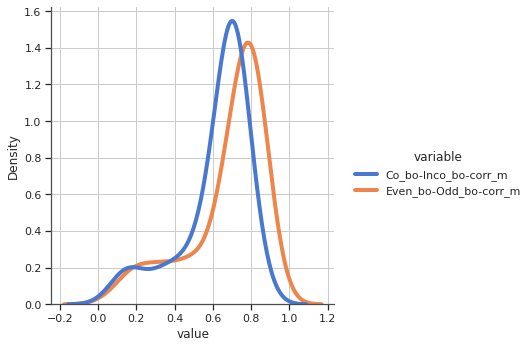

In [145]:
aa = pzrc.loc[pzrc.pop_type=='cells'].melt(id_vars=['subject','session'], value_vars=[test_var,null_var])
aa = aa.dropna()

sns.displot(data=aa, x='value', hue='variable',kind='kde', **dict(lw=4))


<AxesSubplot:xlabel='value', ylabel='Density'>

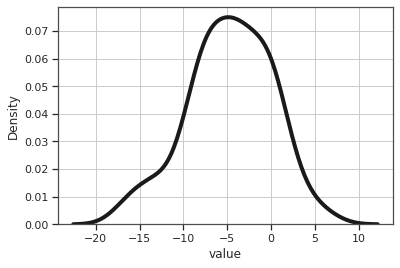

In [147]:
aa = pzrc.loc[pzrc.pop_type=='cells'].melt(id_vars=['subject','session'], value_vars=[z_var])
aa = aa.dropna()

sns.kdeplot(data=aa,x='value',lw=4,color='k')

In [59]:
table = o.result
np.random.seed(0)
subjects = info.subjects
n_subjects= len(subjects)
n_boot = 500
rb = np.zeros((n_subjects,n_boot))*np.nan
for ii, ss in enumerate(subjects):
    sub_table = table.loc[table.subject==ss,['x','y']]
    rb[ii] = bootstrap_corr(sub_table.x.values,sub_table.y.values, n_boot)
boot_behav_remap =pd.DataFrame(rb.T, columns=info.subjects).melt(value_name='r', var_name='subject')

f,ax = plt.subplots(figsize=(0.75,0.75), dpi=600)
fontsize=7
x_split = 0.75
ax.set_position([0,0,x_split,1])

pal = sns.color_palette("tab10", desat=0.8)
sns.set_style(rc={"axes.edgecolor":'0.3',
                 'xtick.bottom': True,
                 'ytick.left': True})

subset = boot_behav_remap.dropna()
sns.pointplot(x='subject', y='r', hue='subject', data=subset, linewidth=0.1, ax=ax, join=False, scale=0.3, errwidth=1, ci='sd', palette=pal, estimator=np.mean)
ax.get_legend().remove()

ax.set_ylim(-1.01,1.01)
ax.set_yticks([-1,0,1])
ax.set_yticklabels([-1, 0, 1], fontsize=fontsize)
ax.set_ylabel(r'$\tau_{(\bar z_{\Delta \tau}, t.p.)}$',fontsize=fontsize)

ax.set_xticklabels([f"s$_{{{ii}}}$" for ii in range(1,len(subjects))], fontsize=fontsize)
ax.set_xlabel('Subjects',fontsize=fontsize)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

#sns.despine(offset=2) #ax.tick_params(axis="both", direction="in", length=2, width=0.8, color="0.5",  which='major', pad=1)
ax.tick_params(axis="both", direction="out", length=3, width=1, color='0.2',  which='major', pad=1, labelsize=fontsize)
ax.grid(linewidth=0.3)

# summary
ax = f.add_axes([x_split,0,1-x_split,1])

scale = 0.05
subset2 = boot_behav_remap.groupby("subject").mean().loc[info.subjects[:-1]]
subset2['color'] = pal[:len(subset2)] 
x_locs = np.random.rand(len(subset2))*scale
x_locs = x_locs-x_locs.mean()
ax.scatter(x_locs, subset2.r, s=5, c=subset2.color, alpha=0.8, lw=0, zorder=10) 

ax.plot(np.array([-1,1])*scale, [subset2.r.mean()]*2, lw=1, color='0.2')
ax.set_ylim(-1.01,1.01)
ax.set_yticks([-1,0,1])
ax.set_yticklabels([])

ax.set_xlim(np.array([-1,1])*scale*2)
ax.set_xticks([0])
ax.set_xticklabels( [r" $\bar s$ "], fontsize=fontsize)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
    
ax.tick_params(axis="both", direction="out", length=3, width=1, color='0.2',  which='major', pad=1, labelsize=fontsize)
ax.tick_params(axis='y', left=False) 
ax.grid(linewidth=0.3)

AttributeError: 'Figure' object has no attribute 'loc'

In [236]:
subset[subset.subject=='Al'].mean()

/tmp/ipykernel_21822/3885765317.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  subset[subset.subject=='Al'].mean()


r   -0.773191
dtype: float64

In [116]:
temp = o.result[1].reset_index()
mdf = smf.mixedlm(formula="y ~ 1 + x + z", groups='subject', re_formula='1', data=temp).fit(reml=True, )
mdnf = smf.mixedlm(formula="y ~ 1 + z ", groups='subject', re_formula='1',  data=temp).fit(reml=True)
print("Full")
print(mdf.summary())
print(f"RMSE: {np.sqrt(((temp.y- mdf.fittedvalues)**2).mean()):0.2f}")
print(f"R2: {rs.get_r2(temp.y.values, mdf.fittedvalues.values)[0]:0.2f}")
print()
print("Null")
print(mdnf.summary())
print(f"RMSE: {np.sqrt(((temp.y- mdnf.fittedvalues)**2).mean()):0.2f}")
print(f"R2: {rs.get_r2(temp.y.values, mdnf.fittedvalues.values)[0]:0.2f}")
print()
print(f"LRT = {(mdf.llf-mdnf.llf):0.2f}")

TypeError: 'Figure' object is not subscriptable

In [31]:
mdf.random_effects

{'Al': subject   -0.194006
 dtype: float64,
 'Ca': subject    0.091365
 dtype: float64,
 'Cl': subject    0.053062
 dtype: float64,
 'Li': subject   -0.120476
 dtype: float64,
 'Ne': subject    0.170054
 dtype: float64}

0.5910378780290038

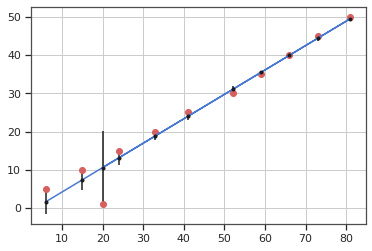

In [50]:
x = np.array([6, 15, 24, 33, 41, 52, 59, 66, 73, 81, 20])
y = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 1])

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)  # to create a linear function with coefficients

plt.plot(x, y, 'ro', x, poly1d_fn(x), '-b')
plt.errorbar(x, poly1d_fn(x), yerr=poly1d_fn(x) - y, fmt='.k')
plt.show()

<AxesSubplot:xlabel='CR_bo-CL_bo-Even_bo-Odd_bo-corr_zm', ylabel='pct_correct'>

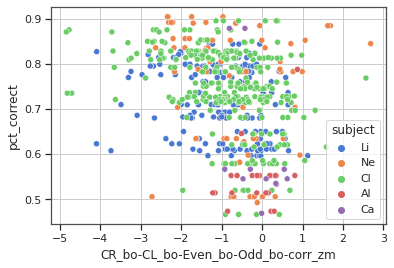

In [62]:
sns.scatterplot(x=z_vars[0], y='pct_correct', data=zrc_b.loc[zrc_b.unit_type=='cell'], hue='subject')

In [13]:
unit_type='all'
remap_score = 'CR-CL_Even-Odd_boot_corr_zz'
remap_null = 'Even-Odd_boot_corr_m'
behav_score = 'pct_correct'
r = np.zeros(6)*np.nan
for ii, ss in enumerate(info.subjects):
    if unit_type == 'all':
        index = (zrc_b.subject==ss)
    else:
        index = (zrc_b.subject==ss) & (zrc_b.unit_type==unit_type)
    if index.sum()>5:
        r[ii]=zrc_b.loc[index, [remap_score, behav_score] ].corr(method='kendall').iloc[0,1]

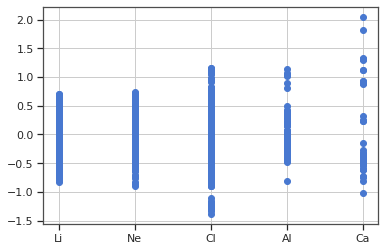

In [119]:
plt.scatter(x=mdf.model.groups, y=mdf.resid)

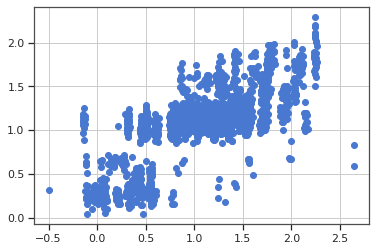

In [121]:
plt.scatter(temp.y.values, mdf.fittedvalues.values)

<AxesSubplot:>

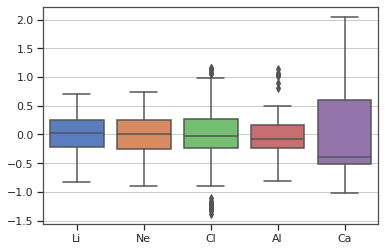

In [120]:
sns.boxplot(x=mdf.model.groups, y=mdf.resid)


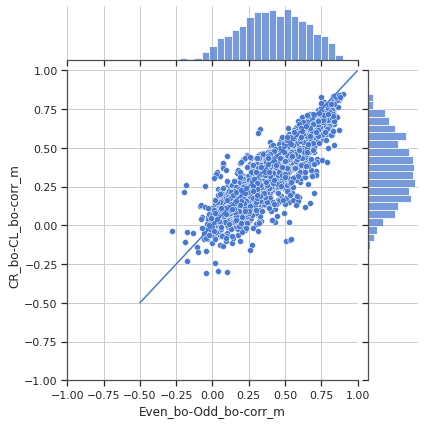

In [118]:
axs = sns.jointplot(data=zrc, x=null_var, y=test_var,xlim=[-1,1],ylim=[-1,1])
axs.ax_joint.plot([-0.5,1],[-0.5,1], )

# plota of zone rates

In [169]:
z_vars_of_interest = [z_vars[2], z_vars[10]]
test_vars_of_interest = [test_vars[7],test_vars[11]]

In [189]:
aligned_seg_rates = seg_rates[seg_rates.cl_name.isin(zr2.cl_name)].copy().set_index('cl_name').copy()
test_seg_rates = aligned_seg_rates[ [c for c in seg_rates.columns if (('-t' in c) & ('Even' not in c) & ('Co_bo' not in c) )]]
control_seg_rates = aligned_seg_rates[ [c for c in seg_rates.columns if (('-t' in c) & ('Even' in c) )]]

#remap2 = zrc[ id_vars+z_vars_of_interest+['cl_name']].copy().set_index('cl_name')
remap2 = zrc[ id_vars+test_vars_of_interest+['cl_name']].copy().set_index('cl_name')

remap_segrate_table = remap2.join(aligned_seg_rates)

ValueError: columns overlap but no suffix specified: Index(['unit_id', 'subject', 'session', 'unit_type'], dtype='object')

In [193]:
remap2.merge(aligned_seg_rates).corr()

,unit_id,CR_bo-CL_bo-corr_m,Co_bi-Inco_bi-corr_m,session_pct_cov,session_valid,session_unit_id,tt,tt_cl,CR_bo-left-m,CR_bo-left-n,...,CR_bo-CL_bo-right-t,CR_bo-CL_bo-right-p,Co_bo-Inco_bo-right-t,Co_bo-Inco_bo-right-p,Co_bi-Inco_bi-right-t,Co_bi-Inco_bi-right-p,Even_bo-Odd_bo-right-t,Even_bo-Odd_bo-right-p,Even_bi-Odd_bi-right-t,Even_bi-Odd_bi-right-p
unit_id,1.000000,-0.342526,-0.288766,NaN,NaN,-0.096867,-0.270276,0.146482,0.005069,-0.318344,...,0.036957,0.111933,0.037775,0.052205,0.122837,0.198188,0.051553,0.125759,0.016608,0.043934
CR_bo-CL_bo-corr_m,-0.342526,1.000000,0.595602,NaN,NaN,-0.054551,0.086312,0.024184,0.266804,0.285958,...,-0.015555,-0.049622,-0.016455,-0.092144,-0.109363,-0.139234,-0.042853,-0.030703,0.002927,0.029936
Co_bi-Inco_bi-corr_m,-0.288766,0.595602,1.000000,NaN,NaN,-0.012153,0.095737,0.028786,0.137751,0.272996,...,-0.004258,-0.017899,-0.005311,-0.030624,-0.219645,-0.177732,-0.070509,-0.047200,-0.026906,0.025395
session_pct_cov,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
session_valid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Co_bi-Inco_bi-right-p,0.198188,-0.139234,-0.177732,NaN,NaN,-0.036902,-0.105414,0.037569,-0.035847,-0.282791,...,0.079151,0.219639,0.080901,0.235454,0.228249,1.000000,0.110769,0.251733,0.105411,0.157706
Even_bo-Odd_bo-right-t,0.051553,-0.042853,-0.070509,NaN,NaN,-0.011791,0.021264,0.036951,0.006197,-0.067735,...,0.007768,0.081622,0.012188,0.075819,0.027213,0.110769,1.000000,0.079248,0.473347,0.118237
Even_bo-Odd_bo-right-p,0.125759,-0.030703,-0.047200,NaN,NaN,-0.017169,-0.060066,-0.007542,0.020841,-0.189704,...,0.058125,0.200960,0.059410,0.146810,0.014461,0.251733,0.079248,1.000000,0.067858,0.229882
Even_bi-Odd_bi-right-t,0.016608,0.002927,-0.026906,NaN,NaN,0.006534,0.037273,0.016134,-0.003960,-0.051968,...,0.011272,0.100681,0.016193,0.067206,0.028286,0.105411,0.473347,0.067858,1.000000,0.072734


<AxesSubplot:>

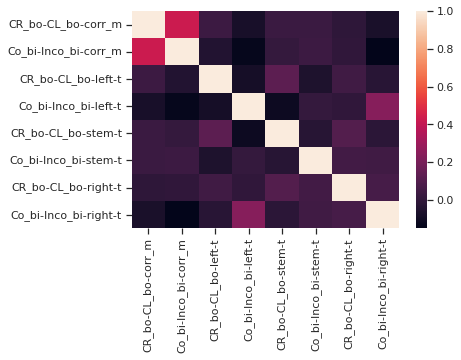

In [177]:
sns.heatmap(remap_segrate_table.drop('unit_id',axis=1).corr(method='kendall'),robust=True)

MemoryError: Unable to allocate 230. TiB for an array with shape (31558841928528,) and data type float64

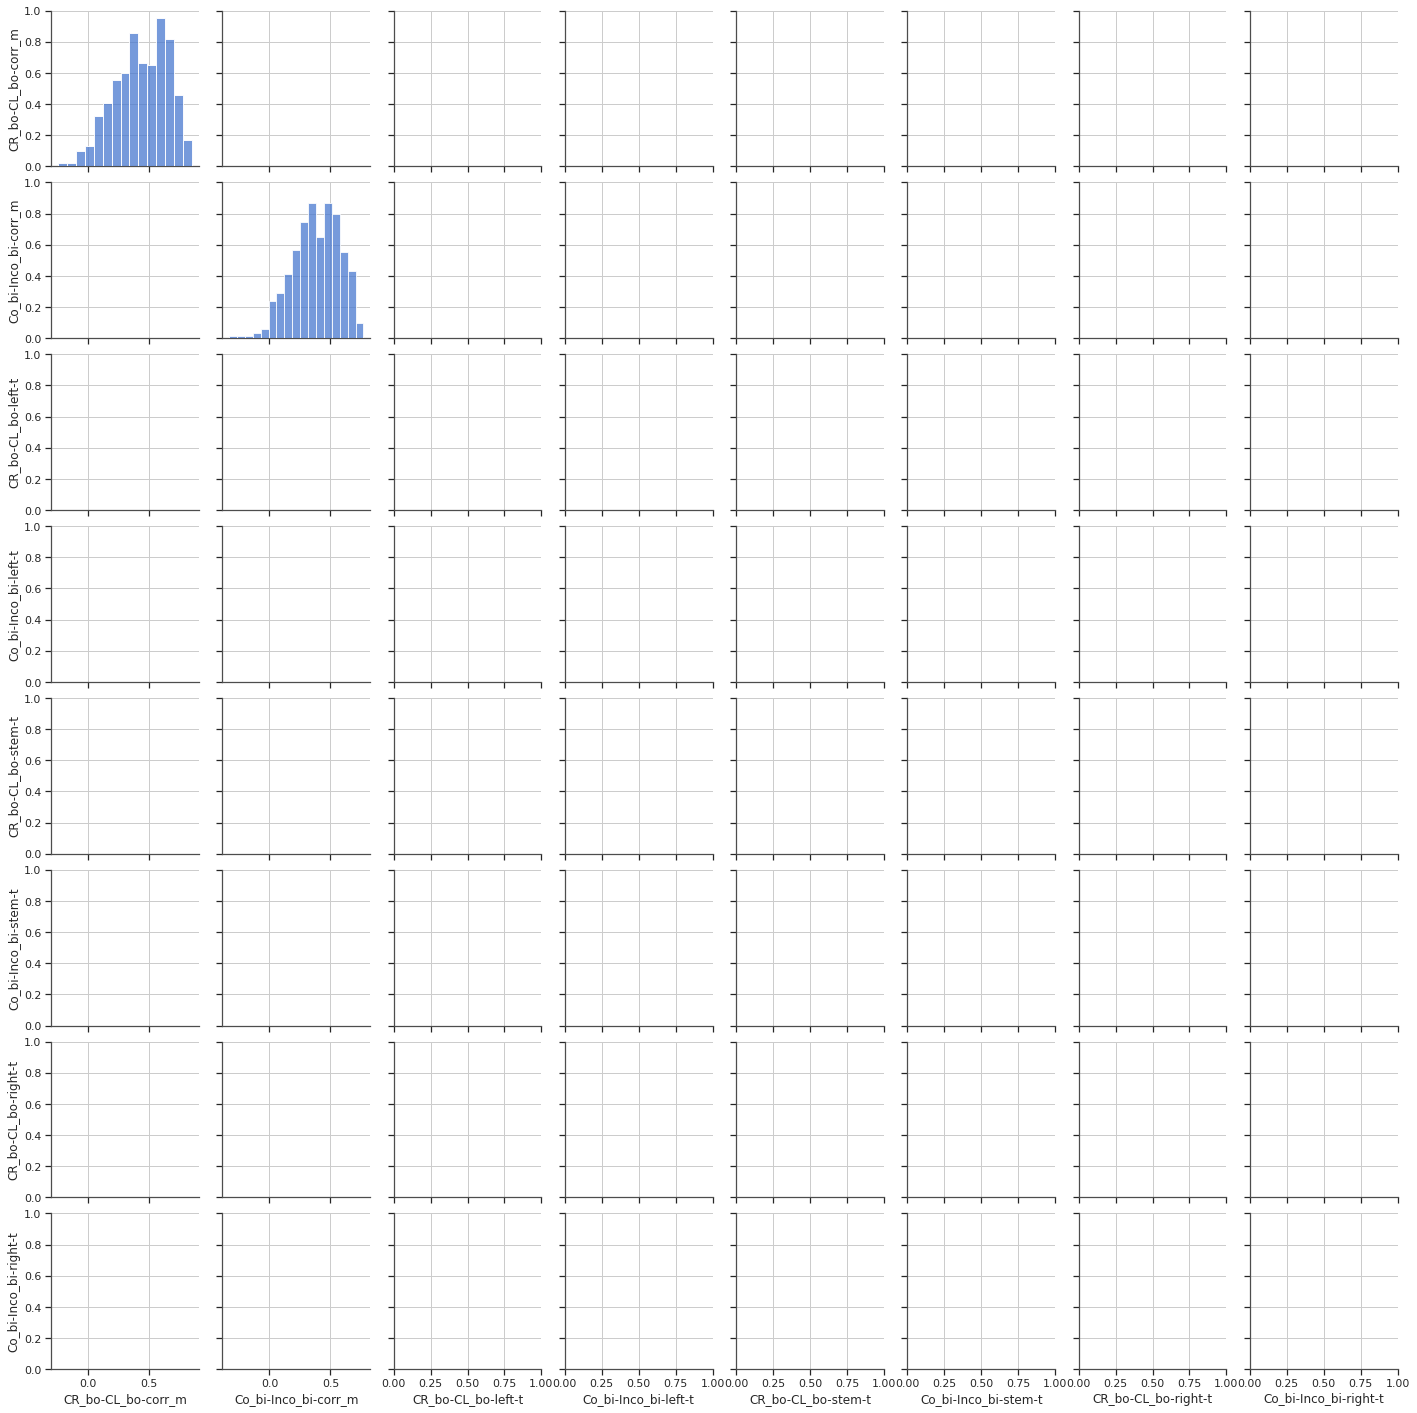

In [175]:
sns.pairplot(remap_segrate_table[remap_segrate_table.unit_type=='cell'].drop('unit_id',axis=1))

In [187]:
control_seg_rates = aligned_seg_rates[ [c for c in seg_rates.columns if (('-t' in c) & ('Even' in c) )]]
control_seg_rates

,Even_bo-Odd_bo-left-t,Even_bi-Odd_bi-left-t,Even_bo-Odd_bo-stem-t,Even_bi-Odd_bi-stem-t,Even_bo-Odd_bo-right-t,Even_bi-Odd_bi-right-t
cl_name,,,,,,
Li_T3g_052818-tt2_d16.5_cl11,-0.238431,-0.122509,-1.030429,0.296569,-1.974652,0.589448
Li_T3g_052818-tt2_d16.5_cl14,0.127292,-0.103381,-0.555849,0.410051,-0.953063,-1.194884
Li_T3g_052918-tt2_d16.5_cl18,-0.950076,0.974690,0.170014,0.894471,-0.874340,0.075705
Li_T3g_052918-tt8_d16.25_cl0,1.315823,-0.844806,-0.138276,-1.544341,-0.113275,0.332199
Li_T3g_052918-tt8_d16.25_cl12,1.441847,-0.083874,0.861830,-0.941912,-1.237119,-1.537541
...,...,...,...,...,...,...
Ca_T3g_040919-tt11_d18.5_cl8,-0.979836,-0.230351,0.315213,0.441591,-1.236415,-0.738202
Ca_T3g_041119-tt11_d18.5_cl13,1.095787,0.782702,-1.114651,0.054772,1.622717,0.030059
Ca_T3g_041619-tt11_d18.75_cl4,0.372000,-0.329210,0.443810,0.360616,-2.323582,-0.617863


In [188]:
test_seg_rates

,CR_bo-CL_bo-left-t,Co_bi-Inco_bi-left-t,CR_bo-CL_bo-stem-t,Co_bi-Inco_bi-stem-t,CR_bo-CL_bo-right-t,Co_bi-Inco_bi-right-t
cl_name,,,,,,
Li_T3g_052818-tt2_d16.5_cl11,-0.004130,3.314418,-2.077900,0.025909,-0.074674,1.994807
Li_T3g_052818-tt2_d16.5_cl14,-0.119833,2.805873,-1.759749,-1.072555,-0.627631,1.971708
Li_T3g_052918-tt2_d16.5_cl18,0.989471,0.008497,-0.358949,1.030155,3.511225,-0.124900
Li_T3g_052918-tt8_d16.25_cl0,0.799708,-2.420195,-1.592478,0.454625,-1.644632,-0.458931
Li_T3g_052918-tt8_d16.25_cl12,0.240483,-0.096493,-0.370451,-3.226466,0.154926,2.113693
...,...,...,...,...,...,...
Ca_T3g_040919-tt11_d18.5_cl8,0.949925,-4.136687,2.168821,0.145215,-1.264172,-4.101205
Ca_T3g_041119-tt11_d18.5_cl13,-1.244690,-0.398671,0.146093,0.048499,-1.706186,0.676719
Ca_T3g_041619-tt11_d18.75_cl4,-2.199863,-2.295468,-1.502852,0.820392,-2.600403,-0.805101


In [167]:
test_vars[7],test_vars[11]

('CR_bo-CL_bo-corr_m', 'Co_bi-Inco_bi-corr_m')

In [154]:
a = remap_segrate_table.melt(id_vars=id_vars, var_name='comp', value_name='score')

In [ ]:
mdoel = smf.mixedlm(formula="y ~ 1 + cue+rw", groups='subject', re_formula='1', vc_formula=vc_formula, data=session_means).fit()